In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
import random
from models_adni import ModelAPIF, ModelBPIF
from hyperparameter_options import params_pif as hyperparams

In [7]:
gpu = 2
multi_gpus = [2, 3]
zero_one_normalize = False

dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
# path to be used for all data sets
train_data_path = "/ritter/share/data/ADNI_HDF5/Splits_Eitel/10xrandom_splits/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_random_state"

In [10]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        #self.X = X
        #self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = z_factor
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [11]:
augmentations = [SagittalFlip()]

In [12]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [13]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    all_outer_bests = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 30) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load data sets
        train_h5 = h5py.File(train_data_path + str(r) + ".h5", 'r')
        val_h5 = h5py.File(train_data_path.replace("train", "val") + str(r) + ".h5", 'r')
        
        X_train, y_train = np.array(train_h5['X']), np.array(train_h5['y'])
        X_val, y_val = val_h5['X'], val_h5['y']
    
        # dataset overview
        y = np.concatenate([np.array(y_train), np.array(y_val)])
        print("# of patients {}, # of healthy controls {}".format(np.sum(y), len(y)-np.sum(y)))

        print(len(y_train))
        print(len(y_val))
        
        if zero_one_normalize:
            intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
            adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
            adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
            adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_h5.close()
        val_h5.close()
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelAPIF"
            elif inner_fold < 4:
                model_name = "ModelBPIF"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])

            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1
            
            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
            
            train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, shuffle=True
            )
            val_loader = DataLoader(
                adni_data_val, batch_size=1, num_workers=1, shuffle=True
            )
        
            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=50,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)        
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models


In [14]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [15]:
r = 0

In [16]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/full_set/10xrandom_splits/experiment/"
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

###### Starting outer fold 0
# of patients 410, # of healthy controls 396
699
107
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69415
[0,   100] loss: 0.69206
[0,   150] loss: 0.69569
Time elapsed: 0h:0m:17s
train accuracy_score: 53.08 %
train balanced_accuracy: 52.67 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.00 %
Val loss: 0.690012
[1,    50] loss: 0.69559
[1,   100] loss: 0.69408
[1,   150] loss: 0.69392
Time elapsed: 0h:0m:33s
train accuracy_score: 49.50 %
train balanced_accuracy: 49.91 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.00 %
Val loss: 0.689834
[2,    50] loss: 0.69524
[2,   100] loss: 0.69431
[2,   150] loss: 0.69337
Time elapsed: 0h:0m:49s
train accuracy_score: 50.79 %
train balanced_accuracy: 51.10 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.693346
[3,    50] loss: 0.69115
[3,   100] loss: 0.69506
[3,   150] loss

[33,    50] loss: 0.25457
[33,   100] loss: 0.40660
[33,   150] loss: 0.32560
Time elapsed: 0h:9m:24s
train accuracy_score: 85.69 %
train balanced_accuracy: 85.69 %
val accuracy_score: 78.50 %
val balanced_accuracy: 77.80 %
Val loss: 0.570003
Early stopping in epoch 34
Total time elapsed: 0h:9m:25s
Writing model to disk...
Best result during training: 0.85. Saving model..
Finished inner fold.


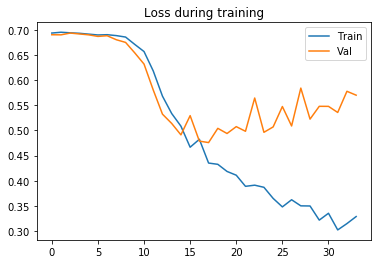

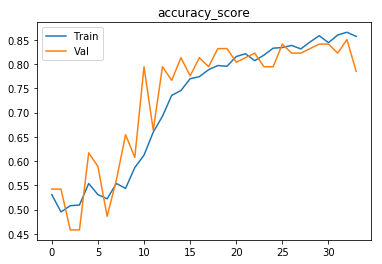

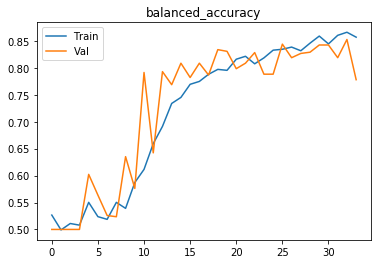

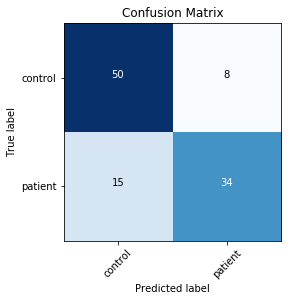

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69412
[0,   100] loss: 0.69650
[0,   150] loss: 0.69659
Time elapsed: 0h:0m:14s
train accuracy_score: 48.21 %
train balanced_accuracy: 48.18 %
val accuracy_score: 56.07 %
val balanced_accuracy: 58.69 %
Val loss: 0.692775
[1,    50] loss: 0.69488
[1,   100] loss: 0.69396
[1,   150] loss: 0.69387
Time elapsed: 0h:0m:31s
train accuracy_score: 48.07 %
train balanced_accuracy: 48.53 %
val accuracy_score: 71.96 %
val balanced_accuracy: 70.65 %
Val loss: 0.692284
[2,    50] loss: 0.69507
[2,   100] loss: 0.69394
[2,   150] loss: 0.69336
Time elapsed: 0h:0m:48s
train accuracy_score: 47.07 %
train balanced_accuracy: 47.51 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.694751
[3,    50] loss: 0.69116
[3,   100] loss: 0.69095
[3,   150] loss: 0.69591
Time elapsed: 0h:1m:4s
train accuracy_score: 52.07 %
train balanced_accu

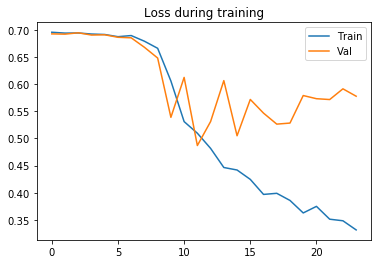

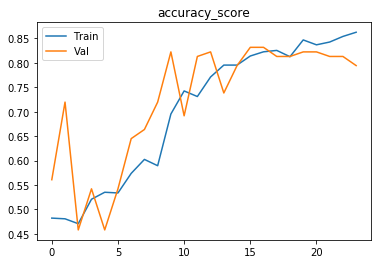

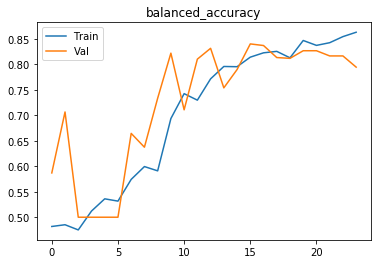

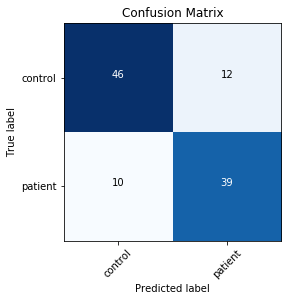

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69431
Time elapsed: 0h:0m:13s
train accuracy_score: 52.79 %
train balanced_accuracy: 52.01 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.00 %
Val loss: 0.690362
[1,    50] loss: 0.69330
Time elapsed: 0h:0m:29s
train accuracy_score: 51.36 %
train balanced_accuracy: 51.20 %
val accuracy_score: 57.94 %
val balanced_accuracy: 54.56 %
Val loss: 0.690133
[2,    50] loss: 0.68958
Time elapsed: 0h:0m:44s
train accuracy_score: 52.36 %
train balanced_accuracy: 52.09 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.00 %
Val loss: 0.682796
[3,    50] loss: 0.68253
Time elapsed: 0h:1m:0s
train accuracy_score: 57.94 %
train balanced_accuracy: 58.09 %
val accuracy_score: 78.50 %
val balanced_accuracy: 79.38 %
Val loss: 0.671155
[4,    50] loss: 0.64573
Time elapsed: 0h:1m:16s
train accuracy_score: 63.23 %
train balanced_accuracy: 62

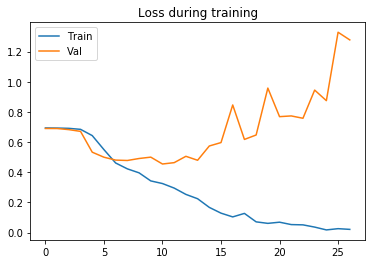

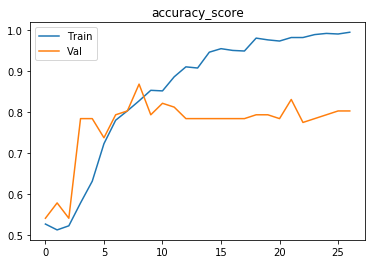

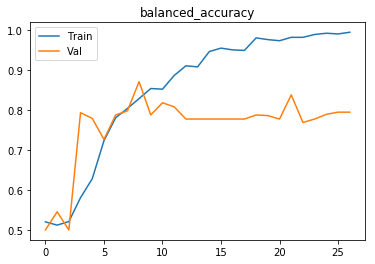

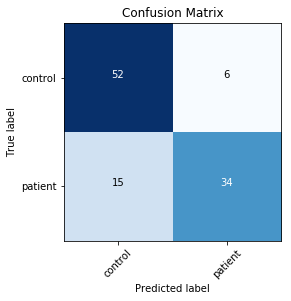

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69202
Time elapsed: 0h:0m:13s
train accuracy_score: 52.36 %
train balanced_accuracy: 51.12 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.48 %
Val loss: 0.691669
[1,    50] loss: 0.69272
Time elapsed: 0h:0m:28s
train accuracy_score: 50.21 %
train balanced_accuracy: 49.19 %
val accuracy_score: 49.53 %
val balanced_accuracy: 52.97 %
Val loss: 0.692289
[2,    50] loss: 0.69273
Time elapsed: 0h:0m:43s
train accuracy_score: 52.50 %
train balanced_accuracy: 51.89 %
val accuracy_score: 66.36 %
val balanced_accuracy: 68.17 %
Val loss: 0.691628
[3,    50] loss: 0.69098
Time elapsed: 0h:0m:59s
train accuracy_score: 52.65 %
train balanced_accuracy: 52.40 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.691037
[4,    50] loss: 0.69094
Time elapsed: 0h:1m:14s
train accuracy_score: 53.51 %
train balanced_accuracy: 52

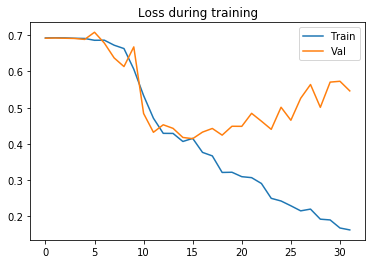

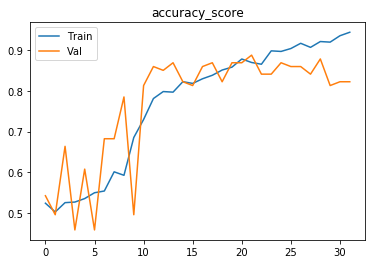

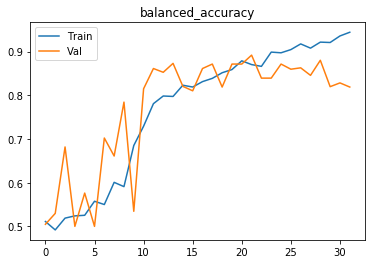

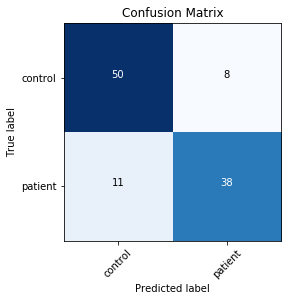

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69553
[0,   100] loss: 0.69583
Time elapsed: 0h:0m:11s
train accuracy_score: 48.78 %
train balanced_accuracy: 47.86 %
val accuracy_score: 53.27 %
val balanced_accuracy: 49.45 %
Val loss: 0.692013
[1,    50] loss: 0.69225
[1,   100] loss: 0.69382
Time elapsed: 0h:0m:24s
train accuracy_score: 52.79 %
train balanced_accuracy: 52.66 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.691589
[2,    50] loss: 0.68948
[2,   100] loss: 0.69113
Time elapsed: 0h:0m:38s
train accuracy_score: 54.36 %
train balanced_accuracy: 54.18 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.688199
[3,    50] loss: 0.67790
[3,   100] loss: 0.66711
Time elapsed: 0h:0m:51s
train accuracy_score: 63.09 %
train balanced_accuracy: 62.97 %
val accuracy_score: 72.90 %
val balanced_accuracy: 74.52 %
Val loss: 0.633835
[4,   

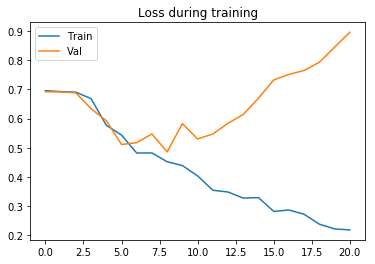

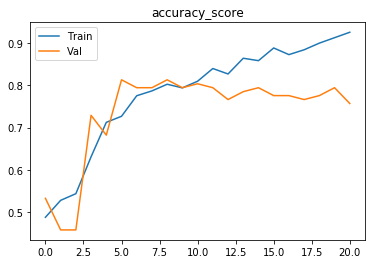

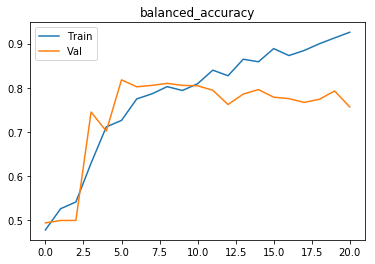

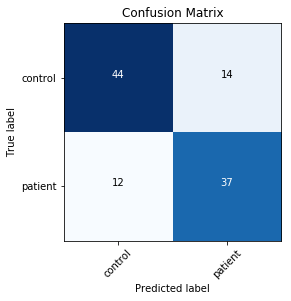

Finished outer fold.
{'final_acc': 0.818789584799437, 'best_acc': 0.8918015482054891, 'final_iter': 32, 'best_iter': 22, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 1
# of patients 398, # of healthy controls 395
698
95
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69467
[0,   100] loss: 0.69191
Time elapsed: 0h:0m:11s
train accuracy_score: 50.14 %
train balanced_accuracy: 49.75 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.705829
[1,    50] loss: 0.69204
[1,   100] loss: 0.69459
Time elapsed: 0h:0m:24s
train accuracy_score: 50.29 %
train balanced_accuracy: 49.80 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.690401
[2,    50] loss: 0.69340
[2,   100] loss: 0.69243
Time elapsed: 0h:0m:38s
train accuracy_score: 50.43 %
train balanced_accuracy: 50.2

[36,    50] loss: 0.18454
[36,   100] loss: 0.19260
Time elapsed: 0h:8m:9s
train accuracy_score: 91.98 %
train balanced_accuracy: 92.00 %
val accuracy_score: 87.37 %
val balanced_accuracy: 87.39 %
Val loss: 0.336765
[37,    50] loss: 0.16744
[37,   100] loss: 0.18170
Time elapsed: 0h:8m:23s
train accuracy_score: 91.98 %
train balanced_accuracy: 92.00 %
val accuracy_score: 87.37 %
val balanced_accuracy: 87.73 %
Val loss: 0.386315
Early stopping in epoch 38
Total time elapsed: 0h:8m:25s
Writing model to disk...
Best result during training: 0.92. Saving model..
Finished inner fold.


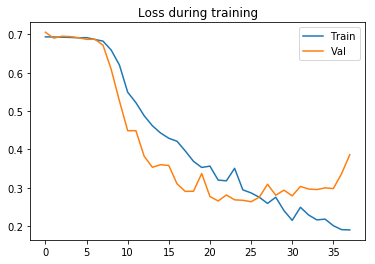

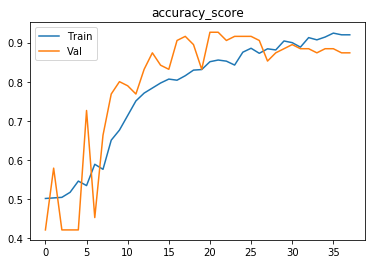

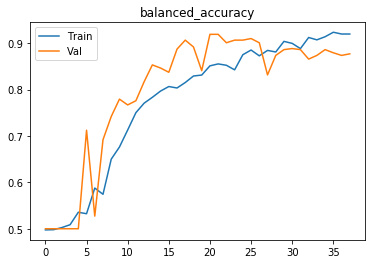

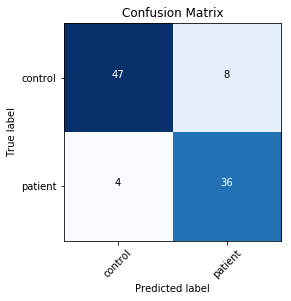

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69285
Time elapsed: 0h:0m:8s
train accuracy_score: 50.29 %
train balanced_accuracy: 49.11 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.695202
[1,    50] loss: 0.69398
Time elapsed: 0h:0m:19s
train accuracy_score: 49.71 %
train balanced_accuracy: 49.95 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.691008
[2,    50] loss: 0.69284
Time elapsed: 0h:0m:29s
train accuracy_score: 50.00 %
train balanced_accuracy: 49.69 %
val accuracy_score: 68.42 %
val balanced_accuracy: 66.59 %
Val loss: 0.691853
[3,    50] loss: 0.69336
Time elapsed: 0h:0m:40s
train accuracy_score: 47.85 %
train balanced_accuracy: 47.44 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.692683
[4,    50] loss: 0.69270
Time elapsed: 0h:0m:50s
train accuracy_score: 50.57 %
train balanced_accuracy: 50.

val accuracy_score: 74.74 %
val balanced_accuracy: 77.50 %
Val loss: 0.435065
[43,    50] loss: 0.41095
Time elapsed: 0h:7m:41s
train accuracy_score: 82.38 %
train balanced_accuracy: 82.44 %
val accuracy_score: 82.11 %
val balanced_accuracy: 81.14 %
Val loss: 0.372819
[44,    50] loss: 0.37046
Time elapsed: 0h:7m:52s
train accuracy_score: 83.81 %
train balanced_accuracy: 83.86 %
val accuracy_score: 81.05 %
val balanced_accuracy: 80.57 %
Val loss: 0.380743
[45,    50] loss: 0.37191
Time elapsed: 0h:8m:2s
train accuracy_score: 82.38 %
train balanced_accuracy: 82.45 %
val accuracy_score: 73.68 %
val balanced_accuracy: 76.59 %
Val loss: 0.495127
[46,    50] loss: 0.37260
Time elapsed: 0h:8m:12s
train accuracy_score: 83.24 %
train balanced_accuracy: 83.29 %
val accuracy_score: 75.79 %
val balanced_accuracy: 77.05 %
Val loss: 0.408452
[47,    50] loss: 0.36311
Time elapsed: 0h:8m:23s
train accuracy_score: 85.82 %
train balanced_accuracy: 85.86 %
val accuracy_score: 75.79 %
val balanced_accur

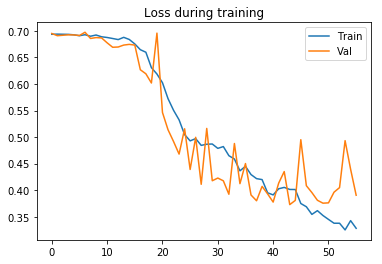

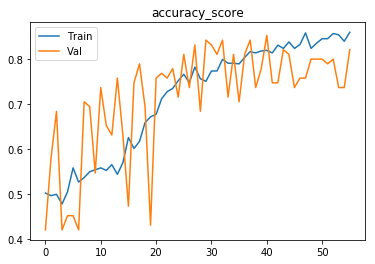

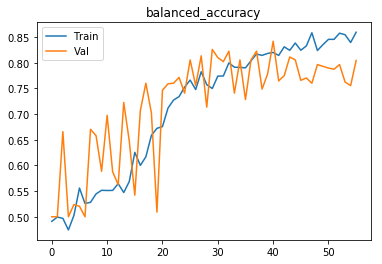

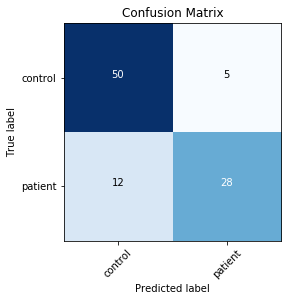

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69806
[0,   100] loss: 0.69529
Time elapsed: 0h:0m:15s
train accuracy_score: 48.42 %
train balanced_accuracy: 48.55 %
val accuracy_score: 63.16 %
val balanced_accuracy: 61.70 %
Val loss: 0.692598
[1,    50] loss: 0.69759
[1,   100] loss: 0.69380
Time elapsed: 0h:0m:33s
train accuracy_score: 50.43 %
train balanced_accuracy: 50.89 %
val accuracy_score: 44.21 %
val balanced_accuracy: 51.82 %
Val loss: 0.693440
[2,    50] loss: 0.69387
[2,   100] loss: 0.70034
Time elapsed: 0h:0m:51s
train accuracy_score: 52.15 %
train balanced_accuracy: 52.73 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.719422
[3,    50] loss: 0.69494
[3,   100] loss: 0.69230
Time elapsed: 0h:1m:9s
train accuracy_score: 52.44 %
train balanced_accuracy: 52.63 %
val accuracy_score: 60.00 %
val balanced_accuracy: 52.50 %
Val loss: 0.682586
[4,    

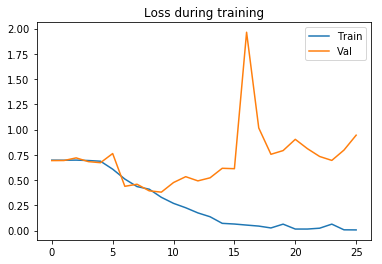

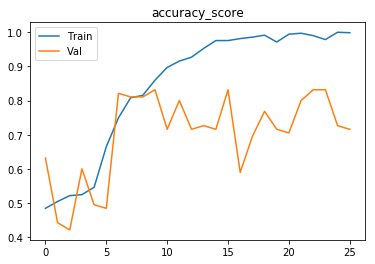

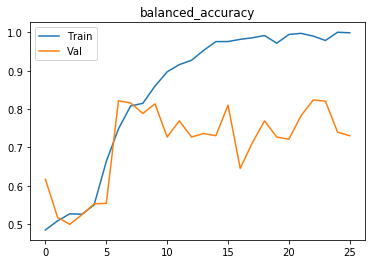

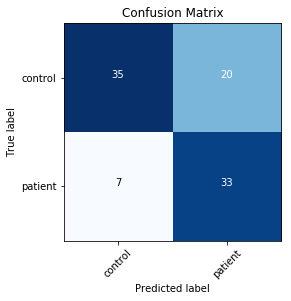

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69557
Time elapsed: 0h:0m:12s
train accuracy_score: 47.42 %
train balanced_accuracy: 47.16 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.690736
[1,    50] loss: 0.69380
Time elapsed: 0h:0m:26s
train accuracy_score: 47.85 %
train balanced_accuracy: 47.82 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687425
[2,    50] loss: 0.69205
Time elapsed: 0h:0m:41s
train accuracy_score: 51.00 %
train balanced_accuracy: 51.59 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.699792
[3,    50] loss: 0.69385
Time elapsed: 0h:0m:55s
train accuracy_score: 50.43 %
train balanced_accuracy: 50.03 %
val accuracy_score: 43.16 %
val balanced_accuracy: 50.91 %
Val loss: 0.692191
[4,    50] loss: 0.69103
Time elapsed: 0h:1m:10s
train accuracy_score: 53.44 %
train balanced_accuracy: 53

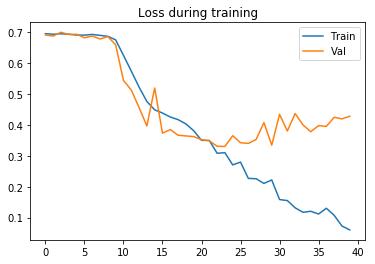

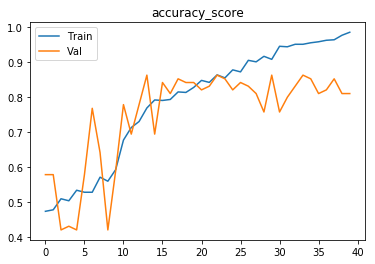

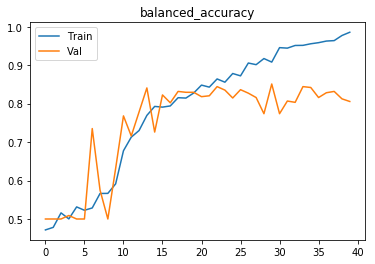

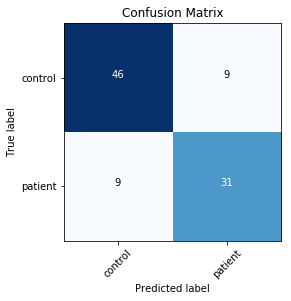

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.70119
[0,   100] loss: 0.69501
[0,   150] loss: 0.69618
Time elapsed: 0h:0m:18s
train accuracy_score: 50.14 %
train balanced_accuracy: 50.69 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.702781
[1,    50] loss: 0.69767
[1,   100] loss: 0.69814
[1,   150] loss: 0.69790
Time elapsed: 0h:0m:40s
train accuracy_score: 49.71 %
train balanced_accuracy: 50.02 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.727114
[2,    50] loss: 0.70424
[2,   100] loss: 0.69494
[2,   150] loss: 0.69525
Time elapsed: 0h:1m:1s
train accuracy_score: 53.01 %
train balanced_accuracy: 53.13 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.678549
[3,    50] loss: 0.69571
[3,   100] loss: 0.68917
[3,   150] loss: 0.68103
Time elapsed: 0h:1m:21s
train accuracy_score: 57.59 %
train balanced_acc

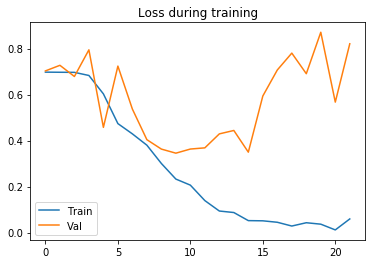

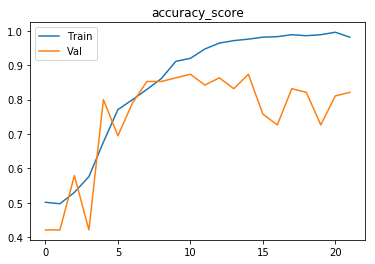

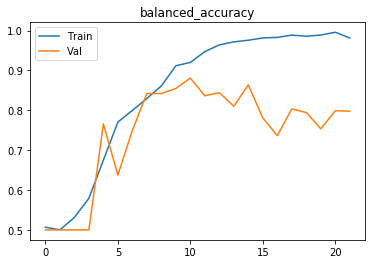

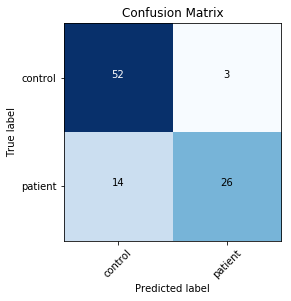

Finished outer fold.
{'final_acc': 0.8772727272727272, 'best_acc': 0.9193181818181817, 'final_iter': 38, 'best_iter': 22, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 0}
###### Starting outer fold 2
# of patients 397, # of healthy controls 394
690
101
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69252
[0,   100] loss: 0.69208
Time elapsed: 0h:0m:10s
train accuracy_score: 53.48 %
train balanced_accuracy: 53.00 %
val accuracy_score: 51.49 %
val balanced_accuracy: 47.27 %
Val loss: 0.691566
[1,    50] loss: 0.69315
[1,   100] loss: 0.68875
Time elapsed: 0h:0m:23s
train accuracy_score: 52.61 %
train balanced_accuracy: 52.38 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.688749
[2,    50] loss: 0.69817
[2,   100] loss: 0.69379
Time elapsed: 0h:0m:36s
train accuracy_score: 48.84 %
train balanced_accuracy: 48

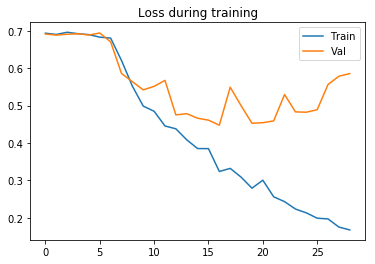

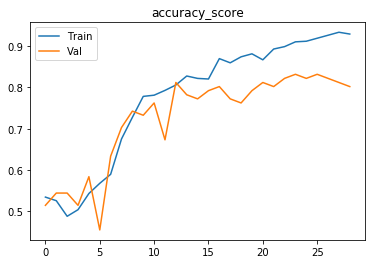

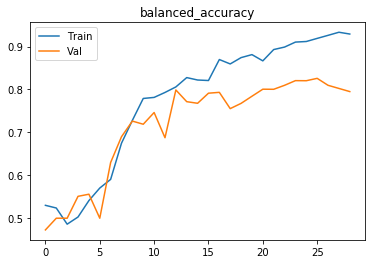

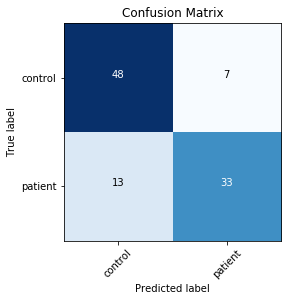

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69343
[0,   100] loss: 0.69866
Time elapsed: 0h:0m:11s
train accuracy_score: 50.43 %
train balanced_accuracy: 50.11 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.691920
[1,    50] loss: 0.69328
[1,   100] loss: 0.69244
Time elapsed: 0h:0m:23s
train accuracy_score: 49.28 %
train balanced_accuracy: 49.83 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695266
[2,    50] loss: 0.69307
[2,   100] loss: 0.69444
Time elapsed: 0h:0m:36s
train accuracy_score: 51.59 %
train balanced_accuracy: 51.44 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692684
[3,    50] loss: 0.69233
[3,   100] loss: 0.69365
Time elapsed: 0h:0m:49s
train accuracy_score: 51.01 %
train balanced_accuracy: 51.17 %
val accuracy_score: 50.50 %
val balanced_accuracy: 54.37 %
Val loss: 0.692768
[4,    

val accuracy_score: 87.13 %
val balanced_accuracy: 86.76 %
Val loss: 0.302792
[38,    50] loss: 0.22610
[38,   100] loss: 0.24562
Time elapsed: 0h:8m:29s
train accuracy_score: 90.43 %
train balanced_accuracy: 90.46 %
val accuracy_score: 89.11 %
val balanced_accuracy: 88.58 %
Val loss: 0.302223
[39,    50] loss: 0.22670
[39,   100] loss: 0.20048
Time elapsed: 0h:8m:42s
train accuracy_score: 90.87 %
train balanced_accuracy: 90.87 %
val accuracy_score: 86.14 %
val balanced_accuracy: 86.56 %
Val loss: 0.355563
[40,    50] loss: 0.23210
[40,   100] loss: 0.23097
Time elapsed: 0h:8m:55s
train accuracy_score: 90.43 %
train balanced_accuracy: 90.43 %
val accuracy_score: 89.11 %
val balanced_accuracy: 88.75 %
Val loss: 0.301400
[41,    50] loss: 0.24220
[41,   100] loss: 0.21136
Time elapsed: 0h:9m:8s
train accuracy_score: 89.71 %
train balanced_accuracy: 89.72 %
val accuracy_score: 84.16 %
val balanced_accuracy: 84.92 %
Val loss: 0.360821
[42,    50] loss: 0.24181
[42,   100] loss: 0.17747
Tim

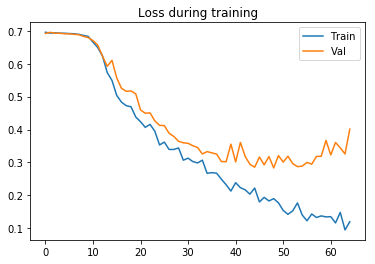

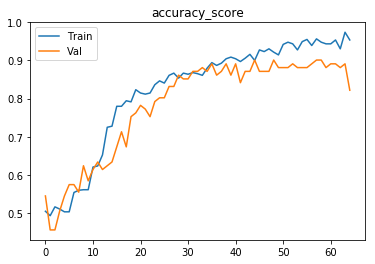

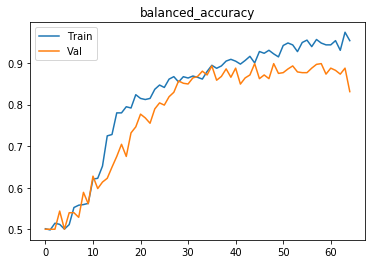

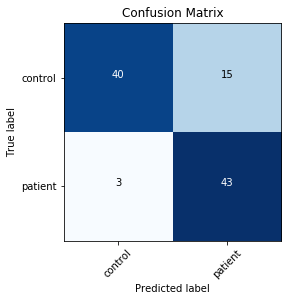

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69274
Time elapsed: 0h:0m:12s
train accuracy_score: 52.46 %
train balanced_accuracy: 52.88 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.696889
[1,    50] loss: 0.69215
Time elapsed: 0h:0m:27s
train accuracy_score: 52.17 %
train balanced_accuracy: 52.31 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.688709
[2,    50] loss: 0.69319
Time elapsed: 0h:0m:42s
train accuracy_score: 51.16 %
train balanced_accuracy: 51.40 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.699651
[3,    50] loss: 0.68753
Time elapsed: 0h:0m:57s
train accuracy_score: 53.62 %
train balanced_accuracy: 53.68 %
val accuracy_score: 66.34 %
val balanced_accuracy: 64.11 %
Val loss: 0.673290
[4,    50] loss: 0.63075
Time elapsed: 0h:1m:12s
train accuracy_score: 66.81 %
train balanced_accuracy: 6

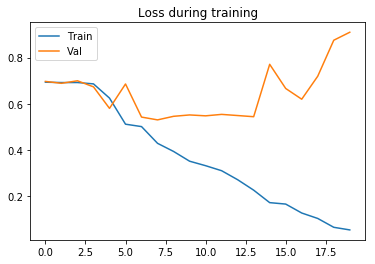

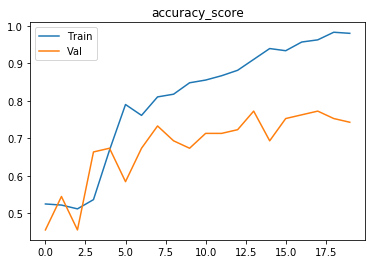

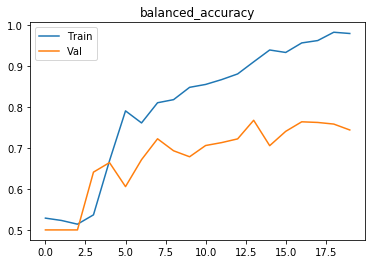

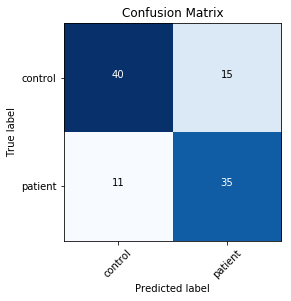

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69634
Time elapsed: 0h:0m:12s
train accuracy_score: 46.38 %
train balanced_accuracy: 46.57 %
val accuracy_score: 53.47 %
val balanced_accuracy: 57.09 %
Val loss: 0.692975
[1,    50] loss: 0.69315
Time elapsed: 0h:0m:27s
train accuracy_score: 54.20 %
train balanced_accuracy: 54.29 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.689179
[2,    50] loss: 0.69336
Time elapsed: 0h:0m:42s
train accuracy_score: 51.30 %
train balanced_accuracy: 51.36 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.687864
[3,    50] loss: 0.69090
Time elapsed: 0h:0m:57s
train accuracy_score: 53.62 %
train balanced_accuracy: 53.86 %
val accuracy_score: 59.41 %
val balanced_accuracy: 55.43 %
Val loss: 0.685012
[4,    50] loss: 0.68864
Time elapsed: 0h:1m:12s
train accuracy_score: 52.46 %
train balanced_accuracy: 5

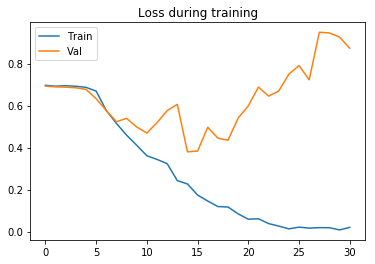

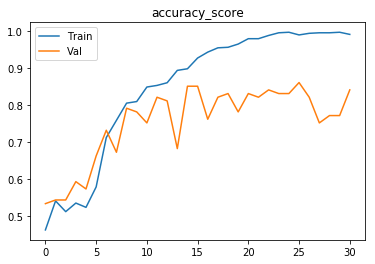

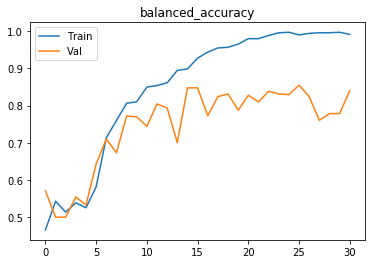

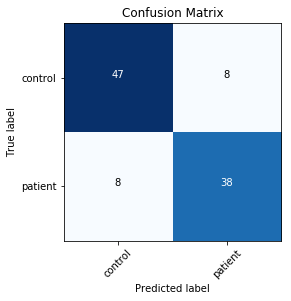

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69604
[0,   100] loss: 0.69764
Time elapsed: 0h:0m:16s
train accuracy_score: 48.55 %
train balanced_accuracy: 48.91 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694313
[1,    50] loss: 0.69775
[1,   100] loss: 0.69847
Time elapsed: 0h:0m:34s
train accuracy_score: 49.57 %
train balanced_accuracy: 49.42 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.691316
[2,    50] loss: 0.69234
[2,   100] loss: 0.69391
Time elapsed: 0h:0m:52s
train accuracy_score: 50.87 %
train balanced_accuracy: 51.06 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693263
[3,    50] loss: 0.69100
[3,   100] loss: 0.69002
Time elapsed: 0h:1m:10s
train accuracy_score: 57.25 %
train balanced_accuracy: 57.31 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.709095
[4,   

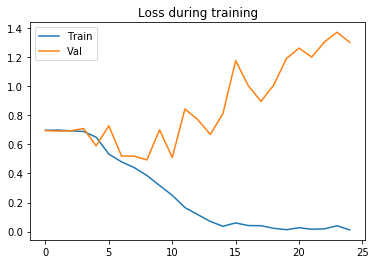

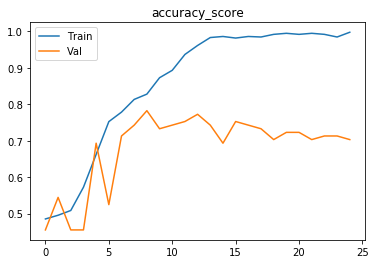

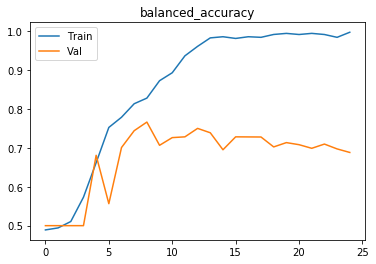

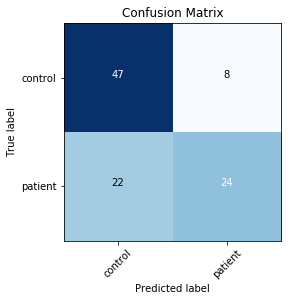

Finished outer fold.
{'final_acc': 0.8310276679841897, 'best_acc': 0.8984189723320157, 'final_iter': 65, 'best_iter': 59, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1}
###### Starting outer fold 3
# of patients 405, # of healthy controls 401
708
98
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69581
[0,   100] loss: 0.69185
[0,   150] loss: 0.69511
Time elapsed: 0h:0m:14s
train accuracy_score: 51.41 %
train balanced_accuracy: 51.99 %
val accuracy_score: 63.27 %
val balanced_accuracy: 52.63 %
Val loss: 0.690433
[1,    50] loss: 0.69346
[1,   100] loss: 0.69443
[1,   150] loss: 0.68894
Time elapsed: 0h:0m:31s
train accuracy_score: 52.40 %
train balanced_accuracy: 52.34 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
Val loss: 0.684189
[2,    50] loss: 0.69333
[2,   100] loss: 0.68968
[2,   150] loss: 0.68263
Time el

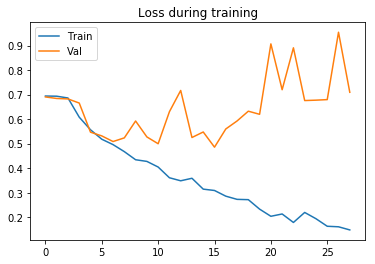

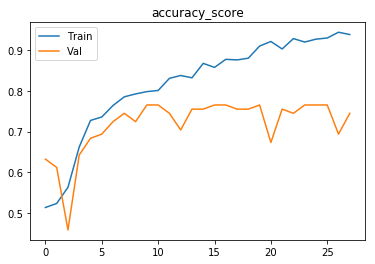

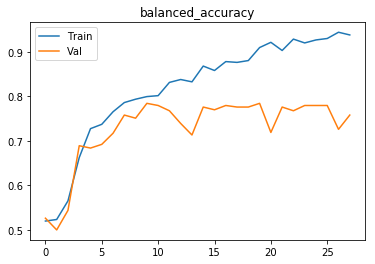

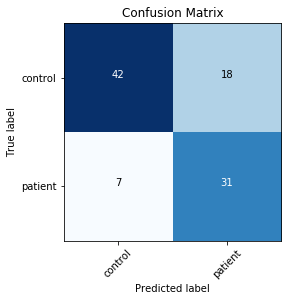

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69594
Time elapsed: 0h:0m:8s
train accuracy_score: 48.16 %
train balanced_accuracy: 48.96 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
Val loss: 0.688962
[1,    50] loss: 0.68821
Time elapsed: 0h:0m:19s
train accuracy_score: 52.68 %
train balanced_accuracy: 51.87 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
Val loss: 0.669650
[2,    50] loss: 0.69411
Time elapsed: 0h:0m:29s
train accuracy_score: 50.85 %
train balanced_accuracy: 51.28 %
val accuracy_score: 62.24 %
val balanced_accuracy: 52.76 %
Val loss: 0.686484
[3,    50] loss: 0.69039
Time elapsed: 0h:0m:40s
train accuracy_score: 56.64 %
train balanced_accuracy: 56.69 %
val accuracy_score: 53.06 %
val balanced_accuracy: 58.77 %
Val loss: 0.688572
[4,    50] loss: 0.68416
Time elapsed: 0h:0m:50s
train accuracy_score: 55.08 %
train balanced_accuracy: 55

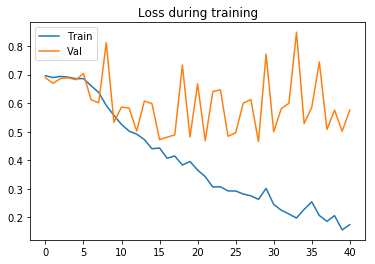

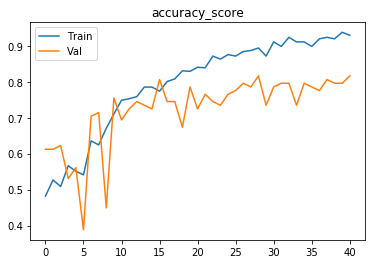

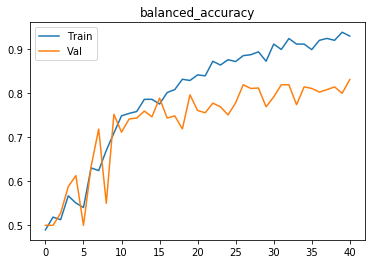

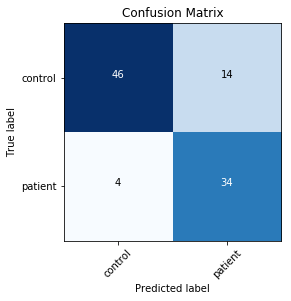

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69241
[0,   100] loss: 0.69600
Time elapsed: 0h:0m:16s
train accuracy_score: 52.12 %
train balanced_accuracy: 50.49 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.699209
[1,    50] loss: 0.69237
[1,   100] loss: 0.69316
Time elapsed: 0h:0m:35s
train accuracy_score: 52.40 %
train balanced_accuracy: 51.11 %
val accuracy_score: 39.80 %
val balanced_accuracy: 50.83 %
Val loss: 0.692601
[2,    50] loss: 0.69028
[2,   100] loss: 0.68907
Time elapsed: 0h:0m:54s
train accuracy_score: 55.65 %
train balanced_accuracy: 55.25 %
val accuracy_score: 75.51 %
val balanced_accuracy: 75.66 %
Val loss: 0.686604
[3,    50] loss: 0.68439
[3,   100] loss: 0.67376
Time elapsed: 0h:1m:13s
train accuracy_score: 62.43 %
train balanced_accuracy: 62.54 %
val accuracy_score: 43.88 %
val balanced_accuracy: 53.20 %
Val loss: 0.686185
[4,    

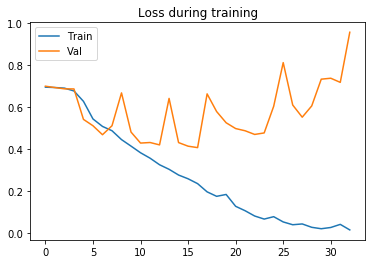

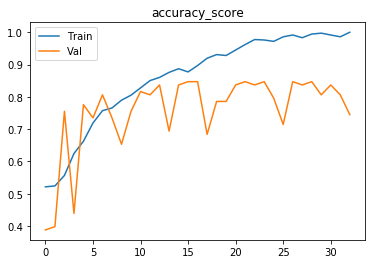

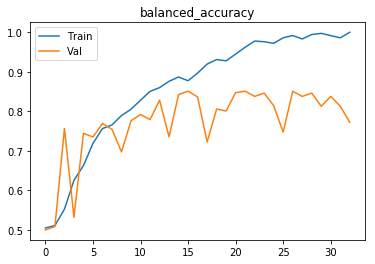

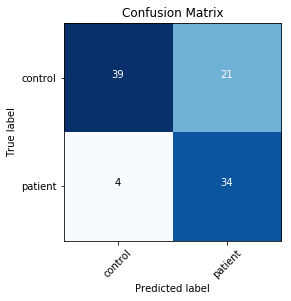

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69396
Time elapsed: 0h:0m:13s
train accuracy_score: 50.99 %
train balanced_accuracy: 51.30 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.724675
[1,    50] loss: 0.69339
Time elapsed: 0h:0m:28s
train accuracy_score: 52.97 %
train balanced_accuracy: 51.57 %
val accuracy_score: 65.31 %
val balanced_accuracy: 67.81 %
Val loss: 0.692018
[2,    50] loss: 0.69160
Time elapsed: 0h:0m:44s
train accuracy_score: 52.82 %
train balanced_accuracy: 51.46 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.694740
[3,    50] loss: 0.69070
Time elapsed: 0h:0m:59s
train accuracy_score: 55.51 %
train balanced_accuracy: 54.92 %
val accuracy_score: 64.29 %
val balanced_accuracy: 55.39 %
Val loss: 0.681509
[4,    50] loss: 0.68535
Time elapsed: 0h:1m:15s
train accuracy_score: 56.92 %
train balanced_accuracy: 56

val accuracy_score: 77.55 %
val balanced_accuracy: 80.22 %
Val loss: 0.624338
[43,    50] loss: 0.08233
Time elapsed: 0h:11m:21s
train accuracy_score: 97.18 %
train balanced_accuracy: 97.20 %
val accuracy_score: 84.69 %
val balanced_accuracy: 86.05 %
Val loss: 0.430974
[44,    50] loss: 0.06578
Time elapsed: 0h:11m:37s
train accuracy_score: 98.31 %
train balanced_accuracy: 98.33 %
val accuracy_score: 76.53 %
val balanced_accuracy: 79.39 %
Val loss: 0.646076
[45,    50] loss: 0.05491
Time elapsed: 0h:11m:52s
train accuracy_score: 97.88 %
train balanced_accuracy: 97.89 %
val accuracy_score: 76.53 %
val balanced_accuracy: 79.39 %
Val loss: 0.599433
[46,    50] loss: 0.06682
Time elapsed: 0h:12m:8s
train accuracy_score: 98.73 %
train balanced_accuracy: 98.72 %
val accuracy_score: 77.55 %
val balanced_accuracy: 80.70 %
Val loss: 0.732240
[47,    50] loss: 0.05071
Time elapsed: 0h:12m:23s
train accuracy_score: 98.45 %
train balanced_accuracy: 98.44 %
val accuracy_score: 83.67 %
val balanced_

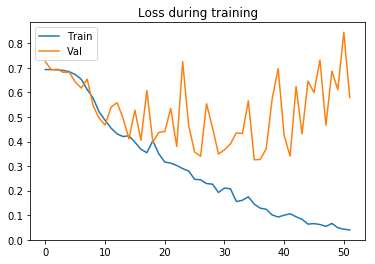

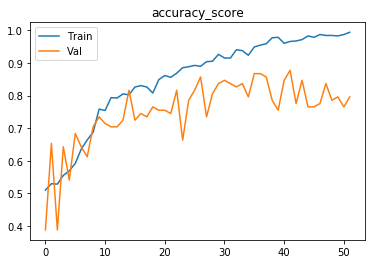

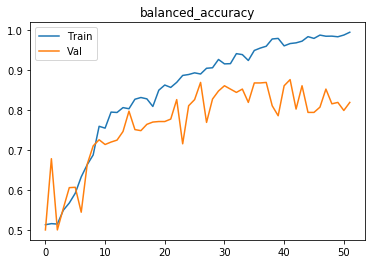

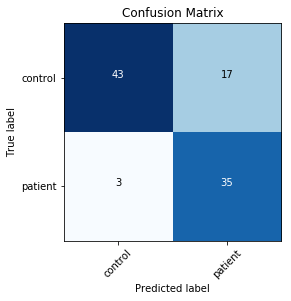

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69579
[0,   100] loss: 0.69122
Time elapsed: 0h:0m:16s
train accuracy_score: 50.28 %
train balanced_accuracy: 48.84 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.697836
[1,    50] loss: 0.69359
[1,   100] loss: 0.69046
Time elapsed: 0h:0m:35s
train accuracy_score: 50.99 %
train balanced_accuracy: 49.74 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.695166
[2,    50] loss: 0.69022
[2,   100] loss: 0.69195
Time elapsed: 0h:0m:53s
train accuracy_score: 51.55 %
train balanced_accuracy: 50.32 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.695269
[3,    50] loss: 0.68514
[3,   100] loss: 0.67949
Time elapsed: 0h:1m:12s
train accuracy_score: 53.67 %
train balanced_accuracy: 53.44 %
val accuracy_score: 69.39 %
val balanced_accuracy: 61.97 %
Val loss: 0.680838
[4,    

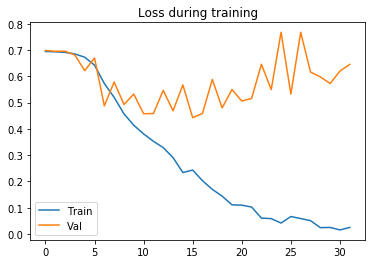

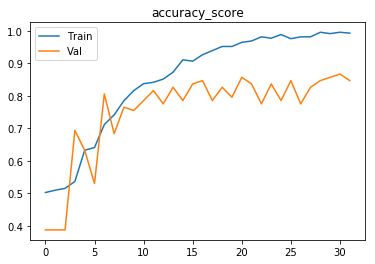

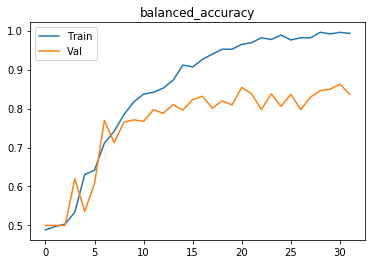

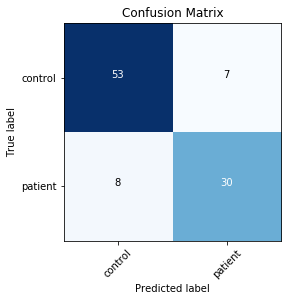

Finished outer fold.
{'final_acc': 0.8307017543859649, 'best_acc': 0.8307017543859649, 'final_iter': 41, 'best_iter': 41, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}
###### Starting outer fold 4
# of patients 402, # of healthy controls 398
696
104
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69494
[0,   100] loss: 0.69514
Time elapsed: 0h:0m:11s
train accuracy_score: 49.43 %
train balanced_accuracy: 48.71 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.694838
[1,    50] loss: 0.69304
[1,   100] loss: 0.69011
Time elapsed: 0h:0m:25s
train accuracy_score: 55.03 %
train balanced_accuracy: 55.10 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.692828
[2,    50] loss: 0.69143
[2,   100] loss: 0.69321
Time elapsed: 0h:0m:39s
train accuracy_score: 52.73 %
train balanced_accuracy: 

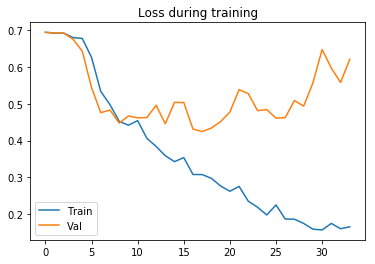

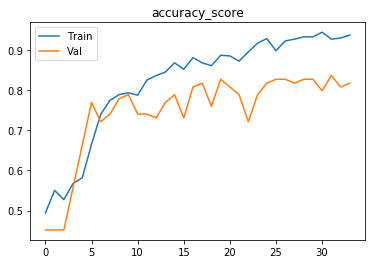

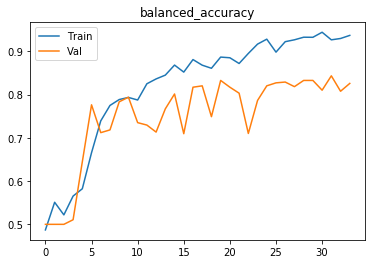

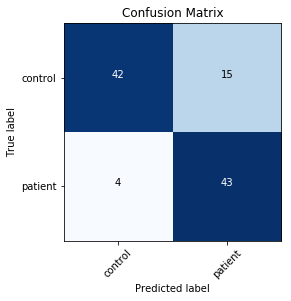

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69602
[0,   100] loss: 0.69338
[0,   150] loss: 0.69407
Time elapsed: 0h:0m:14s
train accuracy_score: 48.28 %
train balanced_accuracy: 48.64 %
val accuracy_score: 56.73 %
val balanced_accuracy: 55.11 %
Val loss: 0.692125
[1,    50] loss: 0.69385
[1,   100] loss: 0.69305
[1,   150] loss: 0.69361
Time elapsed: 0h:0m:31s
train accuracy_score: 49.86 %
train balanced_accuracy: 49.69 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
Val loss: 0.689054
[2,    50] loss: 0.69259
[2,   100] loss: 0.68944
[2,   150] loss: 0.69921
Time elapsed: 0h:0m:47s
train accuracy_score: 52.44 %
train balanced_accuracy: 52.63 %
val accuracy_score: 57.69 %
val balanced_accuracy: 54.87 %
Val loss: 0.687507
[3,    50] loss: 0.68844
[3,   100] loss: 0.68192
[3,   150] loss: 0.68350
Time elapsed: 0h:1m:4s
train accuracy_score: 56.32 %
train balanced_acc

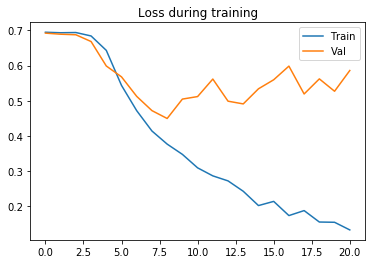

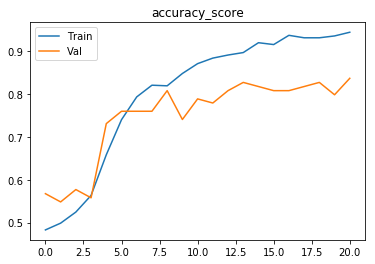

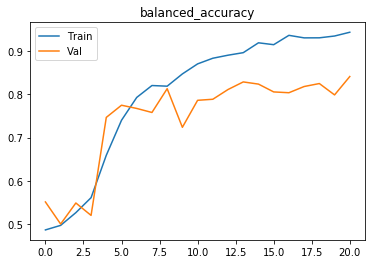

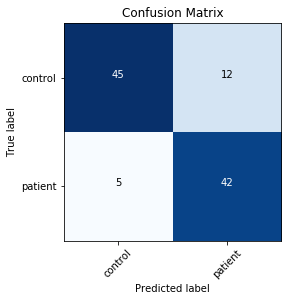

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69544
[0,   100] loss: 0.69442
Time elapsed: 0h:0m:16s
train accuracy_score: 49.14 %
train balanced_accuracy: 50.12 %
val accuracy_score: 67.31 %
val balanced_accuracy: 65.14 %
Val loss: 0.691853
[1,    50] loss: 0.69327
[1,   100] loss: 0.69253
Time elapsed: 0h:0m:34s
train accuracy_score: 50.14 %
train balanced_accuracy: 50.09 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
Val loss: 0.688792
[2,    50] loss: 0.69102
[2,   100] loss: 0.69929
Time elapsed: 0h:0m:53s
train accuracy_score: 52.16 %
train balanced_accuracy: 52.50 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
Val loss: 0.684674
[3,    50] loss: 0.68711
[3,   100] loss: 0.68573
Time elapsed: 0h:1m:11s
train accuracy_score: 55.46 %
train balanced_accuracy: 55.81 %
val accuracy_score: 60.58 %
val balanced_accuracy: 57.32 %
Val loss: 0.674310
[4,    

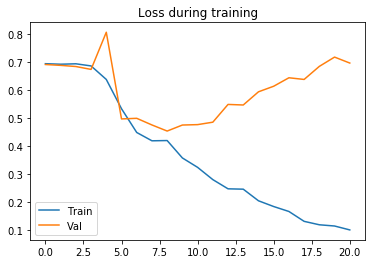

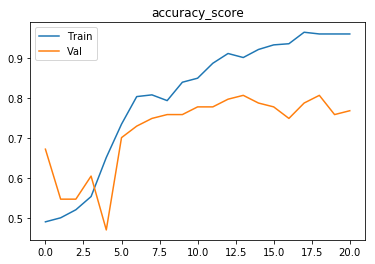

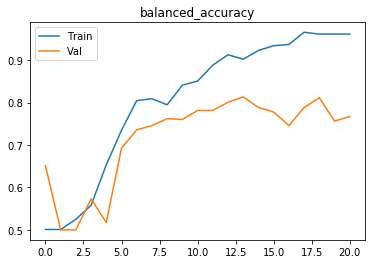

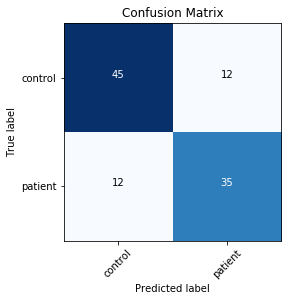

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69619
Time elapsed: 0h:0m:12s
train accuracy_score: 52.01 %
train balanced_accuracy: 51.49 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.699119
[1,    50] loss: 0.69257
Time elapsed: 0h:0m:28s
train accuracy_score: 53.88 %
train balanced_accuracy: 53.37 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
Val loss: 0.688635
[2,    50] loss: 0.69360
Time elapsed: 0h:0m:44s
train accuracy_score: 51.58 %
train balanced_accuracy: 51.64 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.707512
[3,    50] loss: 0.69262
Time elapsed: 0h:0m:59s
train accuracy_score: 56.18 %
train balanced_accuracy: 56.12 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.731763
[4,    50] loss: 0.68429
Time elapsed: 0h:1m:15s
train accuracy_score: 55.60 %
train balanced_accuracy: 5

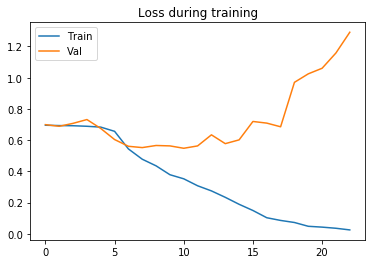

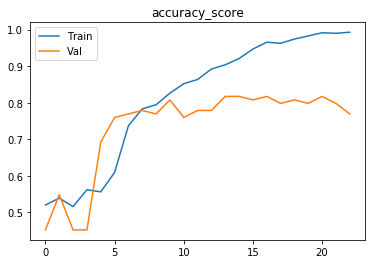

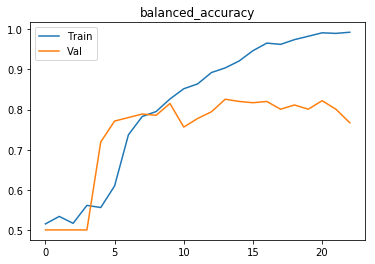

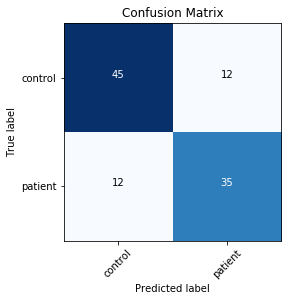

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69598
[0,   100] loss: 0.69600
[0,   150] loss: 0.69187
Time elapsed: 0h:0m:18s
train accuracy_score: 51.44 %
train balanced_accuracy: 51.19 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.695850
[1,    50] loss: 0.69416
[1,   100] loss: 0.69275
[1,   150] loss: 0.69163
Time elapsed: 0h:0m:40s
train accuracy_score: 51.15 %
train balanced_accuracy: 50.45 %
val accuracy_score: 55.77 %
val balanced_accuracy: 59.65 %
Val loss: 0.691150
[2,    50] loss: 0.68923
[2,   100] loss: 0.69297
[2,   150] loss: 0.69055
Time elapsed: 0h:1m:1s
train accuracy_score: 56.32 %
train balanced_accuracy: 55.93 %
val accuracy_score: 61.54 %
val balanced_accuracy: 58.94 %
Val loss: 0.682238
[3,    50] loss: 0.67919
[3,   100] loss: 0.68281
[3,   150] loss: 0.65824
Time elapsed: 0h:1m:23s
train accuracy_score: 62.07 %
train balanced_accu

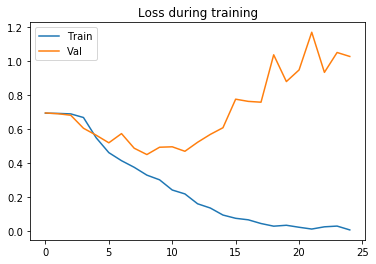

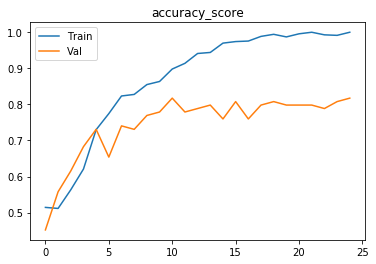

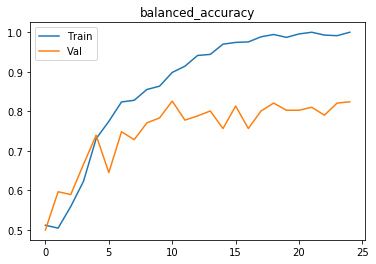

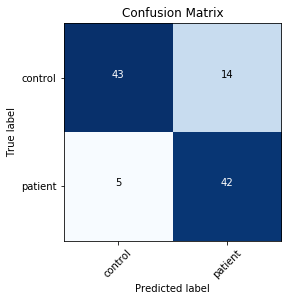

Finished outer fold.
{'final_acc': 0.8258678611422172, 'best_acc': 0.8434117207913402, 'final_iter': 34, 'best_iter': 32, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 5
# of patients 402, # of healthy controls 397
684
115
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69668
[0,   100] loss: 0.69161
[0,   150] loss: 0.69609
Time elapsed: 0h:0m:14s
train accuracy_score: 49.56 %
train balanced_accuracy: 48.84 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.701575
[1,    50] loss: 0.69064
[1,   100] loss: 0.69330
[1,   150] loss: 0.69946
Time elapsed: 0h:0m:31s
train accuracy_score: 50.00 %
train balanced_accuracy: 49.01 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.695895
[2,    50] loss: 0.69218
[2,   100] loss: 0.69045
[2,   150] loss: 0.69428
Time 

[32,   100] loss: 0.06094
[32,   150] loss: 0.07847
Time elapsed: 0h:9m:4s
train accuracy_score: 96.35 %
train balanced_accuracy: 96.36 %
val accuracy_score: 78.26 %
val balanced_accuracy: 80.80 %
Val loss: 0.664499
Early stopping in epoch 33
Total time elapsed: 0h:9m:6s
Writing model to disk...
Best result during training: 0.90. Saving model..
Finished inner fold.


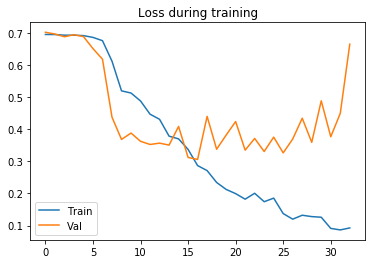

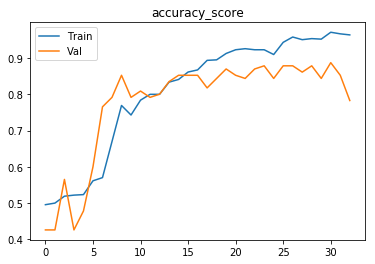

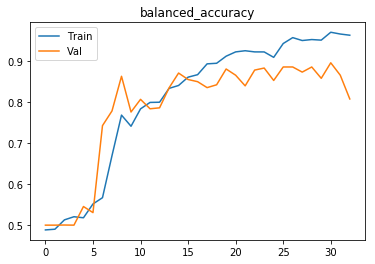

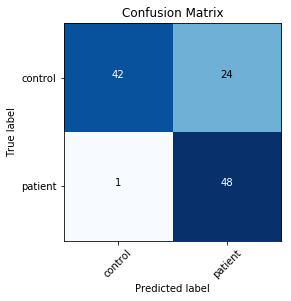

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69311
[0,   100] loss: 0.69575
Time elapsed: 0h:0m:11s
train accuracy_score: 52.49 %
train balanced_accuracy: 51.76 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.697570
[1,    50] loss: 0.69280
[1,   100] loss: 0.69316
Time elapsed: 0h:0m:24s
train accuracy_score: 51.61 %
train balanced_accuracy: 50.15 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.692728
[2,    50] loss: 0.69237
[2,   100] loss: 0.69222
Time elapsed: 0h:0m:38s
train accuracy_score: 54.97 %
train balanced_accuracy: 53.90 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.691556
[3,    50] loss: 0.69454
[3,   100] loss: 0.69013
Time elapsed: 0h:0m:51s
train accuracy_score: 49.12 %
train balanced_accuracy: 48.06 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.691801
[4,   

val accuracy_score: 87.83 %
val balanced_accuracy: 89.39 %
Val loss: 0.421998
Early stopping in epoch 38
Total time elapsed: 0h:8m:31s
Writing model to disk...
Best result during training: 0.89. Saving model..
Finished inner fold.


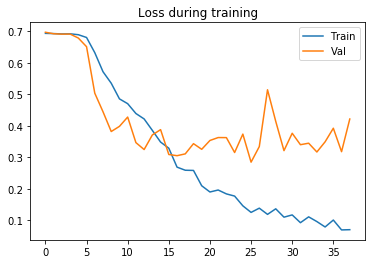

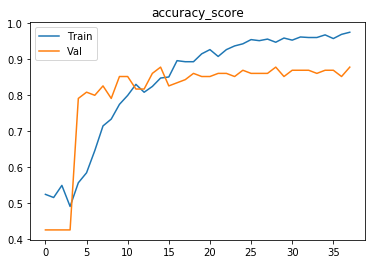

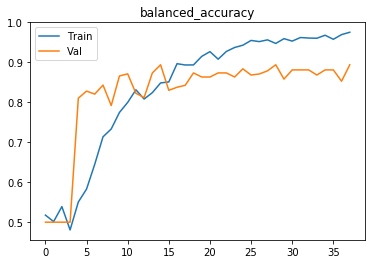

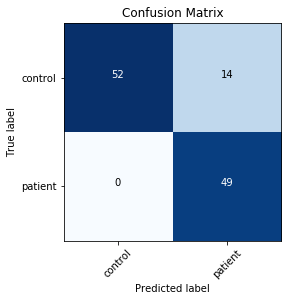

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69647
[0,   100] loss: 0.69368
[0,   150] loss: 0.69444
Time elapsed: 0h:0m:18s
train accuracy_score: 50.44 %
train balanced_accuracy: 49.65 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.693691
[1,    50] loss: 0.69283
[1,   100] loss: 0.69039
[1,   150] loss: 0.69505
Time elapsed: 0h:0m:39s
train accuracy_score: 54.24 %
train balanced_accuracy: 54.08 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.692704
[2,    50] loss: 0.69377
[2,   100] loss: 0.69088
[2,   150] loss: 0.69507
Time elapsed: 0h:1m:1s
train accuracy_score: 51.75 %
train balanced_accuracy: 51.53 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.699877
[3,    50] loss: 0.69211
[3,   100] loss: 0.68885
[3,   150] loss: 0.69313
Time elapsed: 0h:1m:22s
train accuracy_score: 52.78 %
train balanced_accu

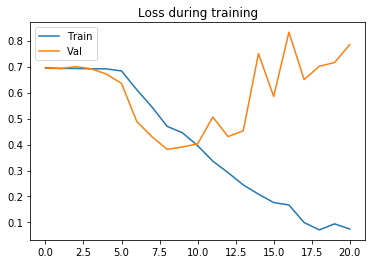

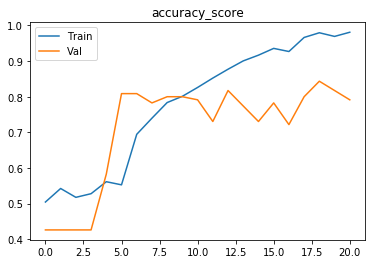

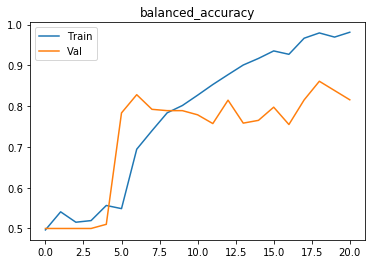

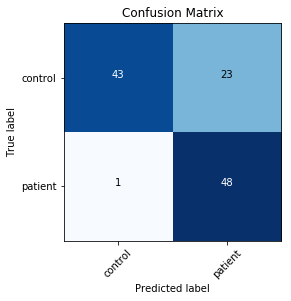

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69579
Time elapsed: 0h:0m:12s
train accuracy_score: 45.91 %
train balanced_accuracy: 46.41 %
val accuracy_score: 44.35 %
val balanced_accuracy: 50.73 %
Val loss: 0.694871
[1,    50] loss: 0.69436
Time elapsed: 0h:0m:28s
train accuracy_score: 48.39 %
train balanced_accuracy: 47.91 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.696461
[2,    50] loss: 0.69343
Time elapsed: 0h:0m:43s
train accuracy_score: 50.58 %
train balanced_accuracy: 50.05 %
val accuracy_score: 69.57 %
val balanced_accuracy: 71.12 %
Val loss: 0.691442
[3,    50] loss: 0.68847
Time elapsed: 0h:0m:59s
train accuracy_score: 53.65 %
train balanced_accuracy: 53.18 %
val accuracy_score: 57.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.678731
[4,    50] loss: 0.69073
Time elapsed: 0h:1m:14s
train accuracy_score: 52.63 %
train balanced_accuracy: 52

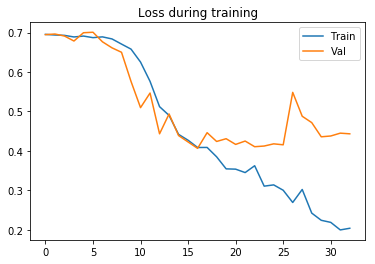

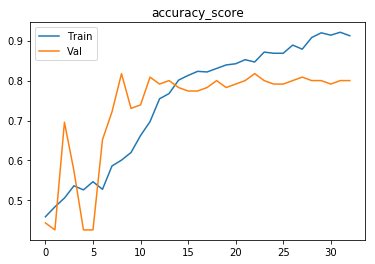

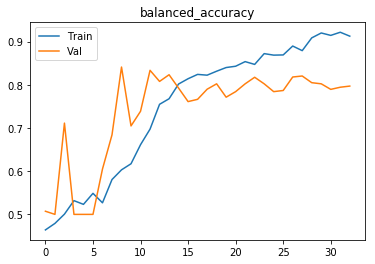

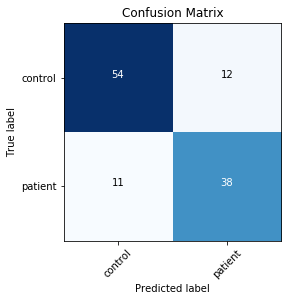

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69378
Time elapsed: 0h:0m:12s
train accuracy_score: 50.44 %
train balanced_accuracy: 49.22 %
val accuracy_score: 55.65 %
val balanced_accuracy: 49.01 %
Val loss: 0.689927
[1,    50] loss: 0.69473
Time elapsed: 0h:0m:28s
train accuracy_score: 50.58 %
train balanced_accuracy: 50.40 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.706782
[2,    50] loss: 0.69280
Time elapsed: 0h:0m:43s
train accuracy_score: 50.29 %
train balanced_accuracy: 48.82 %
val accuracy_score: 69.57 %
val balanced_accuracy: 67.18 %
Val loss: 0.689211
[3,    50] loss: 0.69157
Time elapsed: 0h:0m:58s
train accuracy_score: 52.49 %
train balanced_accuracy: 52.20 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.692325
[4,    50] loss: 0.68993
Time elapsed: 0h:1m:14s
train accuracy_score: 55.70 %
train balanced_accuracy: 5

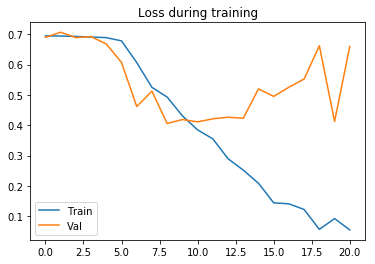

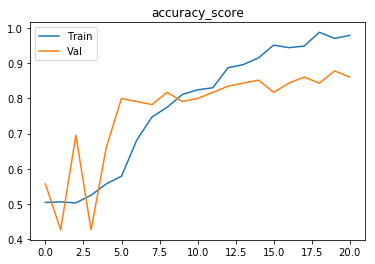

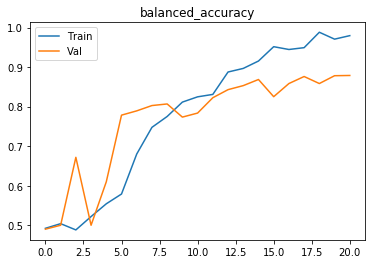

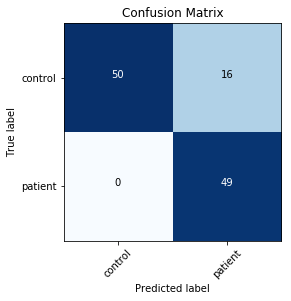

Finished outer fold.
{'final_acc': 0.8939393939393939, 'best_acc': 0.8939393939393939, 'final_iter': 38, 'best_iter': 38, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}
###### Starting outer fold 6
# of patients 407, # of healthy controls 404
708
103
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69511
[0,   100] loss: 0.68817
Time elapsed: 0h:0m:11s
train accuracy_score: 55.37 %
train balanced_accuracy: 55.13 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.699742
[1,    50] loss: 0.69587
[1,   100] loss: 0.69146
Time elapsed: 0h:0m:25s
train accuracy_score: 52.54 %
train balanced_accuracy: 51.84 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.695873
[2,    50] loss: 0.69630
[2,   100] loss: 0.69218
Time elapsed: 0h:0m:39s
train accuracy_score: 50.42 %
train balanced_accuracy: 4

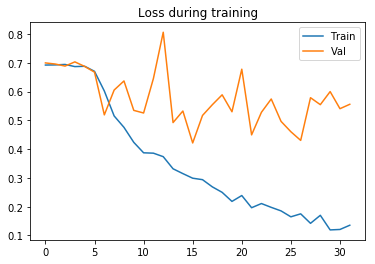

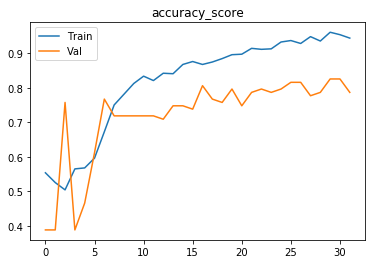

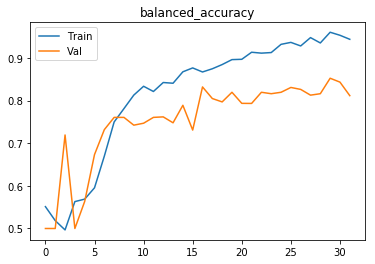

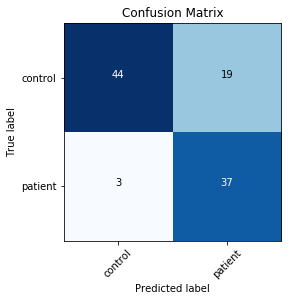

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69840
[0,   100] loss: 0.69263
[0,   150] loss: 0.69337
Time elapsed: 0h:0m:14s
train accuracy_score: 52.68 %
train balanced_accuracy: 52.81 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.695472
[1,    50] loss: 0.69226
[1,   100] loss: 0.69244
[1,   150] loss: 0.68844
Time elapsed: 0h:0m:31s
train accuracy_score: 56.64 %
train balanced_accuracy: 56.38 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.689212
[2,    50] loss: 0.67172
[2,   100] loss: 0.64610
[2,   150] loss: 0.55785
Time elapsed: 0h:0m:48s
train accuracy_score: 66.10 %
train balanced_accuracy: 66.01 %
val accuracy_score: 76.70 %
val balanced_accuracy: 75.93 %
Val loss: 0.530745
[3,    50] loss: 0.47167
[3,   100] loss: 0.44467
[3,   150] loss: 0.47751
Time elapsed: 0h:1m:5s
train accuracy_score: 79.38 %
train balanced_acc

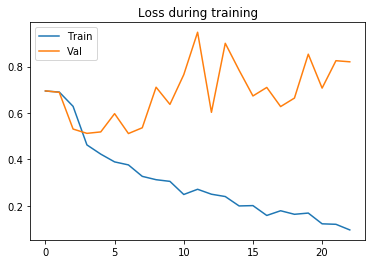

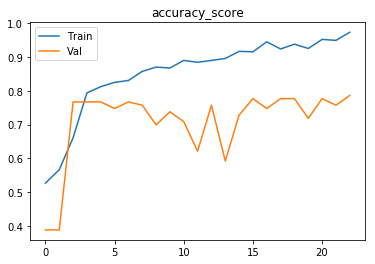

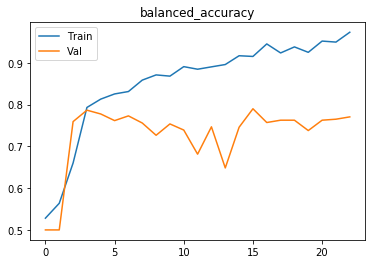

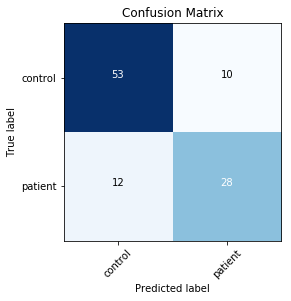

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69671
[0,   100] loss: 0.69492
Time elapsed: 0h:0m:16s
train accuracy_score: 49.44 %
train balanced_accuracy: 50.23 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.703987
[1,    50] loss: 0.69480
[1,   100] loss: 0.69444
Time elapsed: 0h:0m:35s
train accuracy_score: 49.72 %
train balanced_accuracy: 49.38 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
Val loss: 0.678112
[2,    50] loss: 0.69494
[2,   100] loss: 0.69238
Time elapsed: 0h:0m:54s
train accuracy_score: 53.39 %
train balanced_accuracy: 53.23 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
Val loss: 0.683527
[3,    50] loss: 0.69019
[3,   100] loss: 0.68675
Time elapsed: 0h:1m:13s
train accuracy_score: 53.53 %
train balanced_accuracy: 54.12 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.696939
[4,    

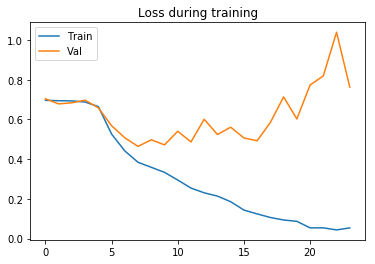

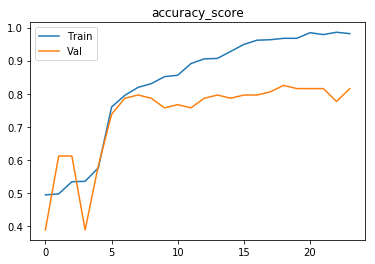

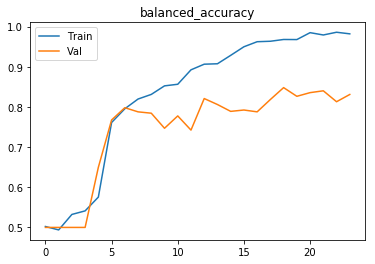

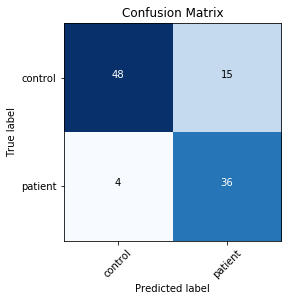

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69409
[0,   100] loss: 0.69383
Time elapsed: 0h:0m:16s
train accuracy_score: 51.98 %
train balanced_accuracy: 50.16 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.701210
[1,    50] loss: 0.69107
[1,   100] loss: 0.69121
Time elapsed: 0h:0m:35s
train accuracy_score: 51.27 %
train balanced_accuracy: 50.20 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.694815
[2,    50] loss: 0.68876
[2,   100] loss: 0.68661
Time elapsed: 0h:0m:54s
train accuracy_score: 55.08 %
train balanced_accuracy: 53.88 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
Val loss: 0.659925
[3,    50] loss: 0.68563
[3,   100] loss: 0.69307
Time elapsed: 0h:1m:12s
train accuracy_score: 55.79 %
train balanced_accuracy: 56.00 %
val accuracy_score: 67.96 %
val balanced_accuracy: 60.12 %
Val loss: 0.655980
[4,    

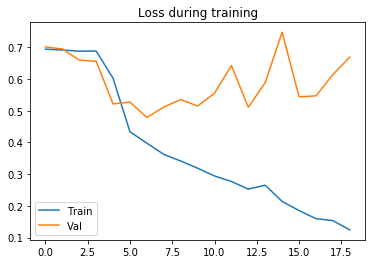

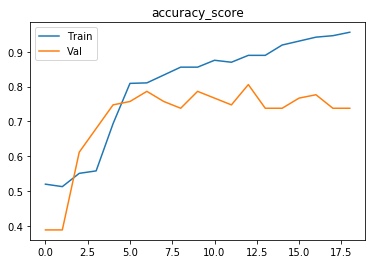

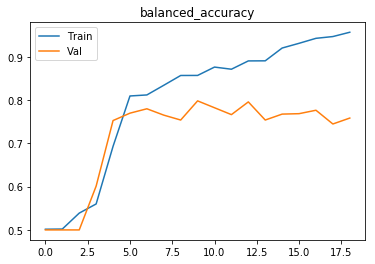

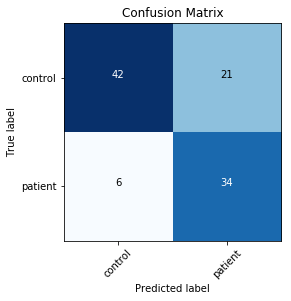

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69310
Time elapsed: 0h:0m:8s
train accuracy_score: 51.41 %
train balanced_accuracy: 52.06 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.703208
[1,    50] loss: 0.69446
Time elapsed: 0h:0m:18s
train accuracy_score: 52.40 %
train balanced_accuracy: 51.01 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.693392
[2,    50] loss: 0.69405
Time elapsed: 0h:0m:29s
train accuracy_score: 49.01 %
train balanced_accuracy: 47.95 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.696874
[3,    50] loss: 0.69354
Time elapsed: 0h:0m:40s
train accuracy_score: 51.41 %
train balanced_accuracy: 49.91 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.699061
[4,    50] loss: 0.69103
Time elapsed: 0h:0m:50s
train accuracy_score: 51.98 %
train balanced_accuracy: 50.

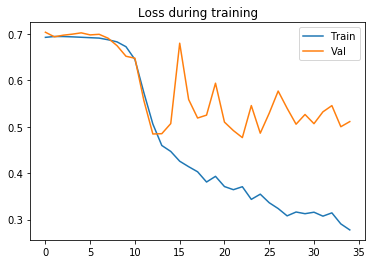

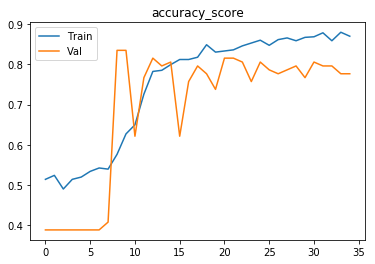

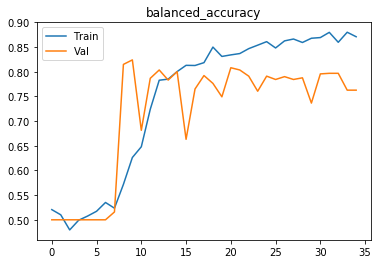

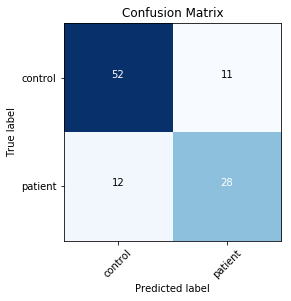

Finished outer fold.
{'final_acc': 0.8309523809523809, 'best_acc': 0.848015873015873, 'final_iter': 24, 'best_iter': 19, 'params': {'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 7
# of patients 401, # of healthy controls 395
702
94
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69464
[0,   100] loss: 0.69529
[0,   150] loss: 0.69254
Time elapsed: 0h:0m:15s
train accuracy_score: 50.85 %
train balanced_accuracy: 51.05 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.692127
[1,    50] loss: 0.69971
[1,   100] loss: 0.68755
[1,   150] loss: 0.69418
Time elapsed: 0h:0m:32s
train accuracy_score: 53.85 %
train balanced_accuracy: 53.79 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.687919
[2,    50] loss: 0.69083
[2,   100] loss: 0.69384
[2,   150] loss: 0.69134
Time ela

[32,   100] loss: 0.13481
[32,   150] loss: 0.12555
Time elapsed: 0h:9m:11s
train accuracy_score: 95.01 %
train balanced_accuracy: 95.02 %
val accuracy_score: 76.60 %
val balanced_accuracy: 75.64 %
Val loss: 0.620203
[33,    50] loss: 0.13504
[33,   100] loss: 0.08047
[33,   150] loss: 0.08150
Time elapsed: 0h:9m:28s
train accuracy_score: 95.58 %
train balanced_accuracy: 95.59 %
val accuracy_score: 75.53 %
val balanced_accuracy: 74.91 %
Val loss: 0.607556
Early stopping in epoch 34
Total time elapsed: 0h:9m:30s
Writing model to disk...
Best result during training: 0.79. Saving model..
Finished inner fold.


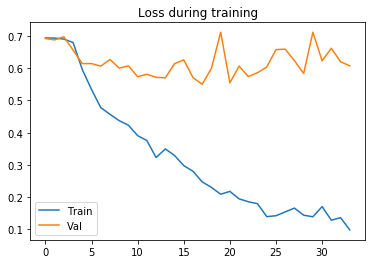

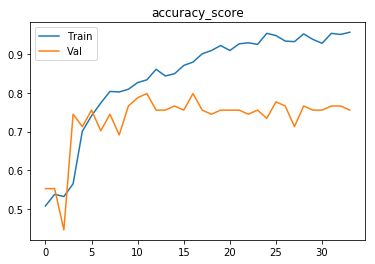

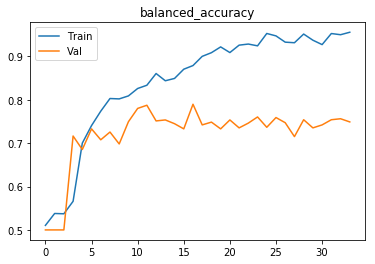

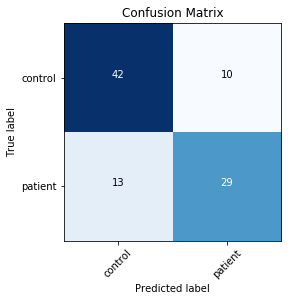

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69340
[0,   100] loss: 0.68641
[0,   150] loss: 0.69828
Time elapsed: 0h:0m:14s
train accuracy_score: 50.43 %
train balanced_accuracy: 50.13 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.698029
[1,    50] loss: 0.69257
[1,   100] loss: 0.69482
[1,   150] loss: 0.69338
Time elapsed: 0h:0m:31s
train accuracy_score: 50.28 %
train balanced_accuracy: 49.28 %
val accuracy_score: 59.57 %
val balanced_accuracy: 54.76 %
Val loss: 0.690536
[2,    50] loss: 0.68479
[2,   100] loss: 0.70116
[2,   150] loss: 0.69361
Time elapsed: 0h:0m:48s
train accuracy_score: 52.71 %
train balanced_accuracy: 52.55 %
val accuracy_score: 47.87 %
val balanced_accuracy: 50.82 %
Val loss: 0.691135
[3,    50] loss: 0.68836
[3,   100] loss: 0.69592
[3,   150] loss: 0.68959
Time elapsed: 0h:1m:4s
train accuracy_score: 52.28 %
train balanced_acc

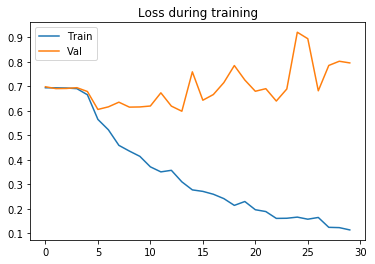

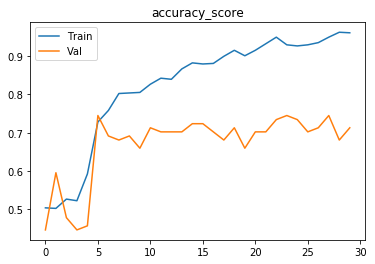

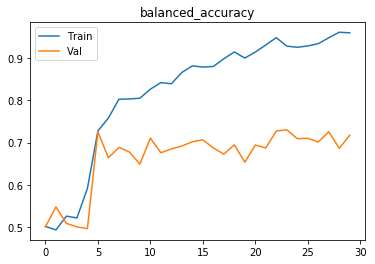

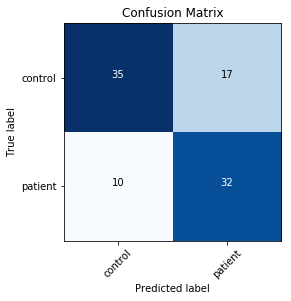

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69009
[0,   100] loss: 0.70862
[0,   150] loss: 0.69682
Time elapsed: 0h:0m:19s
train accuracy_score: 49.15 %
train balanced_accuracy: 49.45 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.693896
[1,    50] loss: 0.69631
[1,   100] loss: 0.69500
[1,   150] loss: 0.69366
Time elapsed: 0h:0m:40s
train accuracy_score: 49.15 %
train balanced_accuracy: 49.45 %
val accuracy_score: 64.89 %
val balanced_accuracy: 60.71 %
Val loss: 0.691164
[2,    50] loss: 0.69210
[2,   100] loss: 0.69238
[2,   150] loss: 0.69079
Time elapsed: 0h:1m:2s
train accuracy_score: 51.99 %
train balanced_accuracy: 51.56 %
val accuracy_score: 58.51 %
val balanced_accuracy: 53.57 %
Val loss: 0.682741
[3,    50] loss: 0.68319
[3,   100] loss: 0.66813
[3,   150] loss: 0.64208
Time elapsed: 0h:1m:23s
train accuracy_score: 63.39 %
train balanced_acc

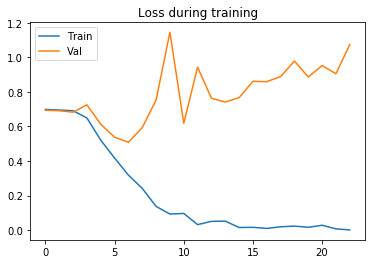

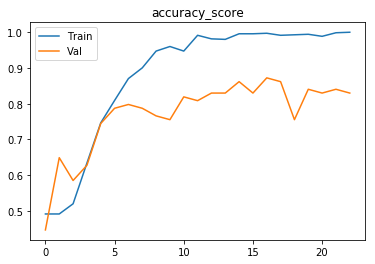

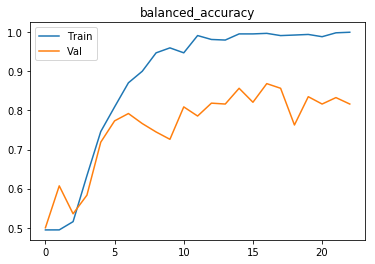

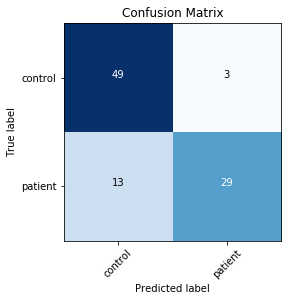

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69407
[0,   100] loss: 0.69416
Time elapsed: 0h:0m:16s
train accuracy_score: 50.71 %
train balanced_accuracy: 50.01 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.697299
[1,    50] loss: 0.69384
[1,   100] loss: 0.69421
Time elapsed: 0h:0m:34s
train accuracy_score: 51.71 %
train balanced_accuracy: 51.27 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.692446
[2,    50] loss: 0.68910
[2,   100] loss: 0.68765
Time elapsed: 0h:0m:53s
train accuracy_score: 57.41 %
train balanced_accuracy: 56.84 %
val accuracy_score: 57.45 %
val balanced_accuracy: 52.38 %
Val loss: 0.680811
[3,    50] loss: 0.68755
[3,   100] loss: 0.67238
Time elapsed: 0h:1m:11s
train accuracy_score: 60.97 %
train balanced_accuracy: 60.96 %
val accuracy_score: 57.45 %
val balanced_accuracy: 52.38 %
Val loss: 0.649306
[4,    

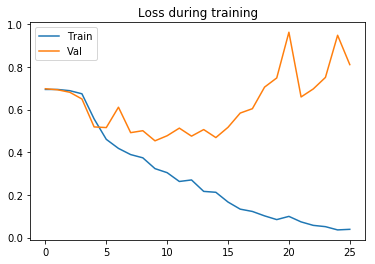

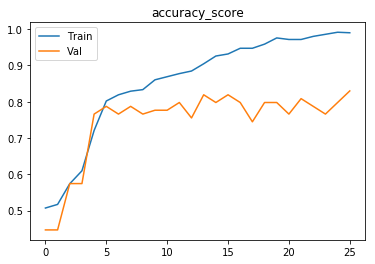

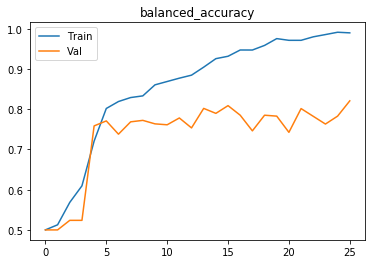

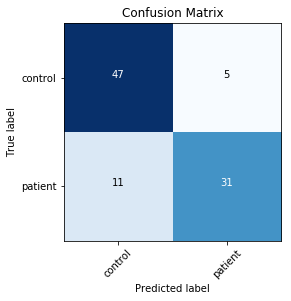

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69268
Time elapsed: 0h:0m:8s
train accuracy_score: 50.85 %
train balanced_accuracy: 49.87 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.691258
[1,    50] loss: 0.69291
Time elapsed: 0h:0m:19s
train accuracy_score: 51.71 %
train balanced_accuracy: 51.53 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.697139
[2,    50] loss: 0.69247
Time elapsed: 0h:0m:29s
train accuracy_score: 51.00 %
train balanced_accuracy: 50.93 %
val accuracy_score: 46.81 %
val balanced_accuracy: 51.92 %
Val loss: 0.692267
[3,    50] loss: 0.69370
Time elapsed: 0h:0m:40s
train accuracy_score: 51.28 %
train balanced_accuracy: 50.75 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.688012
[4,    50] loss: 0.69086
Time elapsed: 0h:0m:51s
train accuracy_score: 53.85 %
train balanced_accuracy: 53

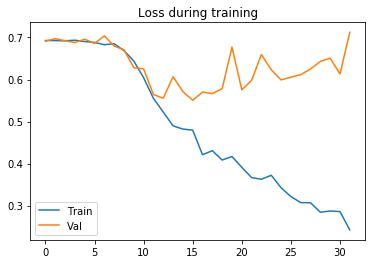

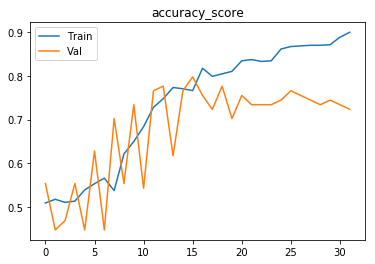

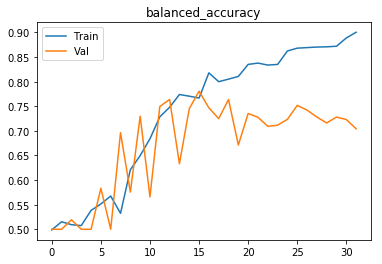

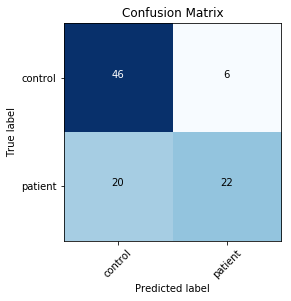

Finished outer fold.
{'final_acc': 0.8163919413919415, 'best_acc': 0.8685897435897436, 'final_iter': 23, 'best_iter': 17, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}
###### Starting outer fold 8
# of patients 396, # of healthy controls 395
692
99
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69723
[0,   100] loss: 0.69324
[0,   150] loss: 0.69509
Time elapsed: 0h:0m:14s
train accuracy_score: 51.01 %
train balanced_accuracy: 49.72 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.696436
[1,    50] loss: 0.69391
[1,   100] loss: 0.69211
[1,   150] loss: 0.69098
Time elapsed: 0h:0m:32s
train accuracy_score: 54.05 %
train balanced_accuracy: 54.39 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.771662
[2,    50] loss: 0.70252
[2,   100] loss: 0.69093
[2,   150] loss: 0.69207
Time el

[32,   100] loss: 0.20665
[32,   150] loss: 0.25231
Time elapsed: 0h:9m:4s
train accuracy_score: 88.15 %
train balanced_accuracy: 88.17 %
val accuracy_score: 80.81 %
val balanced_accuracy: 77.44 %
Val loss: 0.398388
[33,    50] loss: 0.24218
[33,   100] loss: 0.24142
[33,   150] loss: 0.21474
Time elapsed: 0h:9m:20s
train accuracy_score: 90.90 %
train balanced_accuracy: 90.89 %
val accuracy_score: 78.79 %
val balanced_accuracy: 82.05 %
Val loss: 0.443097
[34,    50] loss: 0.23161
[34,   100] loss: 0.26320
[34,   150] loss: 0.19508
Time elapsed: 0h:9m:37s
train accuracy_score: 89.74 %
train balanced_accuracy: 89.76 %
val accuracy_score: 81.82 %
val balanced_accuracy: 81.41 %
Val loss: 0.344139
[35,    50] loss: 0.23195
[35,   100] loss: 0.22956
[35,   150] loss: 0.19437
Time elapsed: 0h:9m:53s
train accuracy_score: 91.04 %
train balanced_accuracy: 91.05 %
val accuracy_score: 81.82 %
val balanced_accuracy: 81.41 %
Val loss: 0.356243
[36,    50] loss: 0.20004
[36,   100] loss: 0.14674
[36

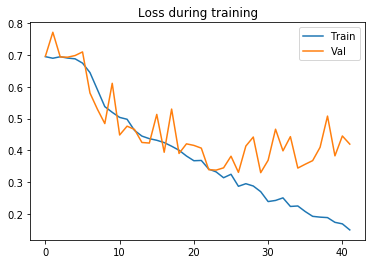

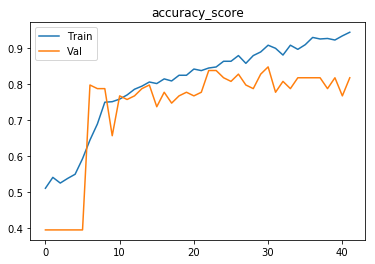

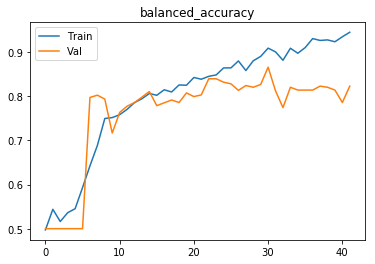

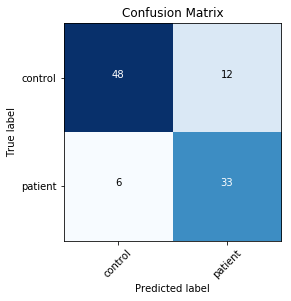

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69542
[0,   100] loss: 0.69295
Time elapsed: 0h:0m:11s
train accuracy_score: 49.28 %
train balanced_accuracy: 48.42 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.696315
[1,    50] loss: 0.69211
[1,   100] loss: 0.69107
Time elapsed: 0h:0m:24s
train accuracy_score: 52.60 %
train balanced_accuracy: 51.64 %
val accuracy_score: 56.57 %
val balanced_accuracy: 46.67 %
Val loss: 0.689583
[2,    50] loss: 0.69222
[2,   100] loss: 0.69227
Time elapsed: 0h:0m:38s
train accuracy_score: 53.03 %
train balanced_accuracy: 52.65 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.686901
[3,    50] loss: 0.69097
[3,   100] loss: 0.68719
Time elapsed: 0h:0m:51s
train accuracy_score: 55.64 %
train balanced_accuracy: 55.68 %
val accuracy_score: 61.62 %
val balanced_accuracy: 66.99 %
Val loss: 0.688275
[4,    

val accuracy_score: 85.86 %
val balanced_accuracy: 86.99 %
Val loss: 0.324565
[38,    50] loss: 0.27831
[38,   100] loss: 0.25269
Time elapsed: 0h:8m:43s
train accuracy_score: 87.43 %
train balanced_accuracy: 87.50 %
val accuracy_score: 87.88 %
val balanced_accuracy: 89.10 %
Val loss: 0.318410
[39,    50] loss: 0.26282
[39,   100] loss: 0.26867
Time elapsed: 0h:8m:57s
train accuracy_score: 87.28 %
train balanced_accuracy: 87.31 %
val accuracy_score: 85.86 %
val balanced_accuracy: 85.64 %
Val loss: 0.288794
[40,    50] loss: 0.28345
[40,   100] loss: 0.25720
Time elapsed: 0h:9m:10s
train accuracy_score: 87.57 %
train balanced_accuracy: 87.62 %
val accuracy_score: 83.84 %
val balanced_accuracy: 86.67 %
Val loss: 0.420653
[41,    50] loss: 0.27242
[41,   100] loss: 0.25752
Time elapsed: 0h:9m:24s
train accuracy_score: 87.86 %
train balanced_accuracy: 87.89 %
val accuracy_score: 86.87 %
val balanced_accuracy: 87.37 %
Val loss: 0.313779
[42,    50] loss: 0.24315
[42,   100] loss: 0.27801
Ti

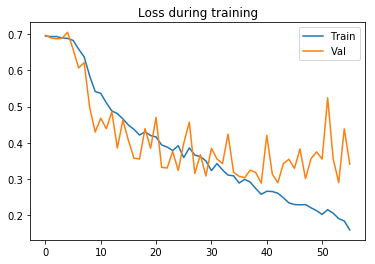

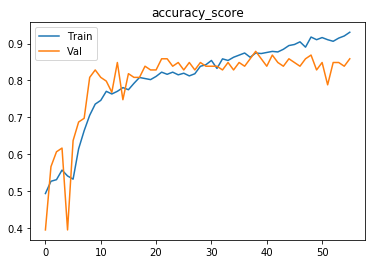

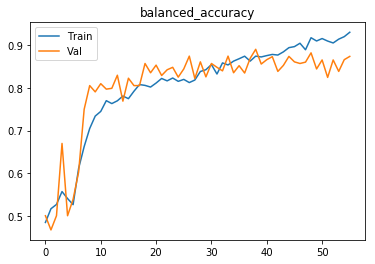

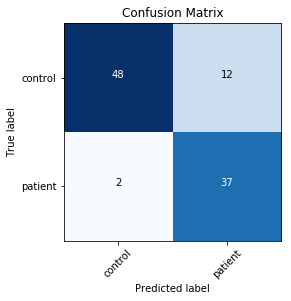

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69761
Time elapsed: 0h:0m:12s
train accuracy_score: 49.42 %
train balanced_accuracy: 49.40 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.691663
[1,    50] loss: 0.69291
Time elapsed: 0h:0m:27s
train accuracy_score: 52.46 %
train balanced_accuracy: 52.04 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.694885
[2,    50] loss: 0.69441
Time elapsed: 0h:0m:42s
train accuracy_score: 52.60 %
train balanced_accuracy: 52.24 %
val accuracy_score: 73.74 %
val balanced_accuracy: 67.12 %
Val loss: 0.690401
[3,    50] loss: 0.69233
Time elapsed: 0h:0m:58s
train accuracy_score: 52.75 %
train balanced_accuracy: 52.76 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.708959
[4,    50] loss: 0.69126
Time elapsed: 0h:1m:13s
train accuracy_score: 53.18 %
train balanced_accuracy: 5

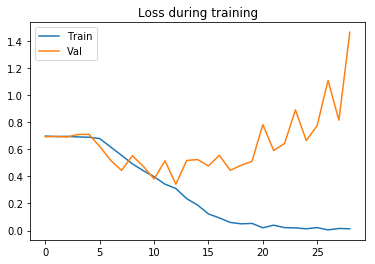

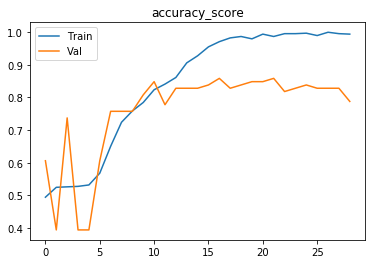

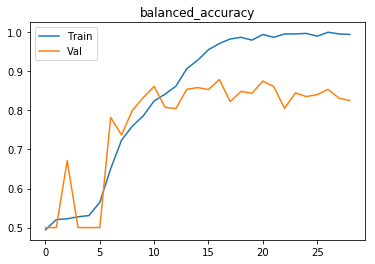

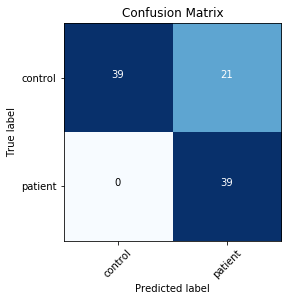

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69732
[0,   100] loss: 0.69806
[0,   150] loss: 0.69271
Time elapsed: 0h:0m:18s
train accuracy_score: 49.57 %
train balanced_accuracy: 49.75 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.688684
[1,    50] loss: 0.69321
[1,   100] loss: 0.70805
[1,   150] loss: 0.69703
Time elapsed: 0h:0m:40s
train accuracy_score: 51.73 %
train balanced_accuracy: 51.33 %
val accuracy_score: 54.55 %
val balanced_accuracy: 62.50 %
Val loss: 0.692227
[2,    50] loss: 0.69265
[2,   100] loss: 0.69183
[2,   150] loss: 0.69425
Time elapsed: 0h:1m:1s
train accuracy_score: 53.32 %
train balanced_accuracy: 53.11 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.693066
[3,    50] loss: 0.69177
[3,   100] loss: 0.68899
[3,   150] loss: 0.68809
Time elapsed: 0h:1m:22s
train accuracy_score: 52.60 %
train balanced_acc

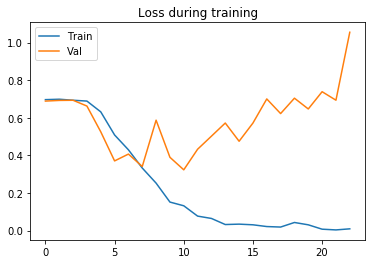

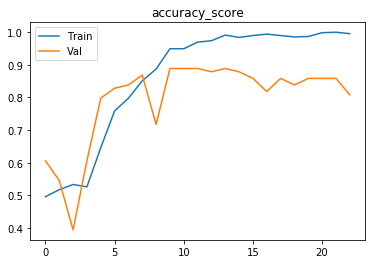

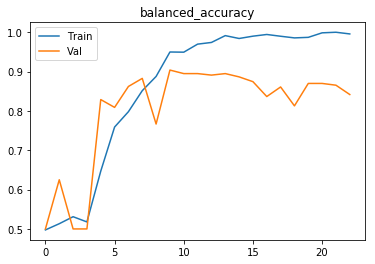

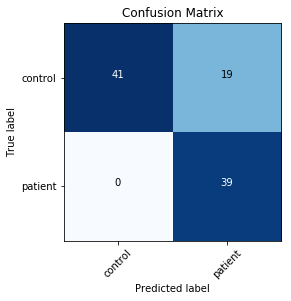

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69775
[0,   100] loss: 0.69589
[0,   150] loss: 0.69550
Time elapsed: 0h:0m:18s
train accuracy_score: 47.83 %
train balanced_accuracy: 47.99 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.699123
[1,    50] loss: 0.69619
[1,   100] loss: 0.69491
[1,   150] loss: 0.69756
Time elapsed: 0h:0m:40s
train accuracy_score: 51.88 %
train balanced_accuracy: 51.44 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.690151
[2,    50] loss: 0.69327
[2,   100] loss: 0.69385
[2,   150] loss: 0.69284
Time elapsed: 0h:1m:1s
train accuracy_score: 53.18 %
train balanced_accuracy: 52.98 %
val accuracy_score: 72.73 %
val balanced_accuracy: 72.56 %
Val loss: 0.688323
[3,    50] loss: 0.69053
[3,   100] loss: 0.69224
[3,   150] loss: 0.67928
Time elapsed: 0h:1m:22s
train accuracy_score: 59.10 %
train balanced_acc

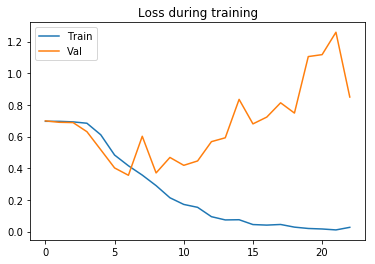

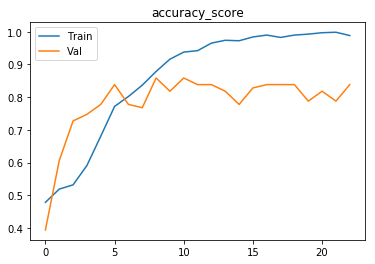

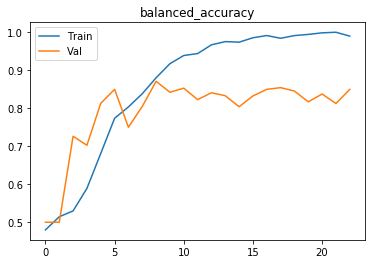

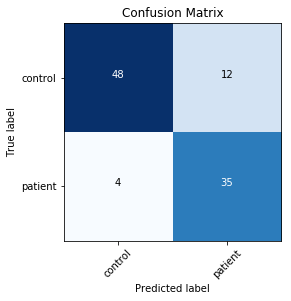

Finished outer fold.
{'final_acc': 0.8743589743589744, 'best_acc': 0.891025641025641, 'final_iter': 56, 'best_iter': 39, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1}
###### Starting outer fold 9
# of patients 403, # of healthy controls 398
689
112
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69660
[0,   100] loss: 0.69256
[0,   150] loss: 0.69505
Time elapsed: 0h:0m:14s
train accuracy_score: 48.19 %
train balanced_accuracy: 47.76 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693575
[1,    50] loss: 0.69367
[1,   100] loss: 0.69476
[1,   150] loss: 0.69307
Time elapsed: 0h:0m:31s
train accuracy_score: 50.65 %
train balanced_accuracy: 50.14 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.690124
[2,    50] loss: 0.69184
[2,   100] loss: 0.69120
[2,   150] loss: 0.69037
Time el

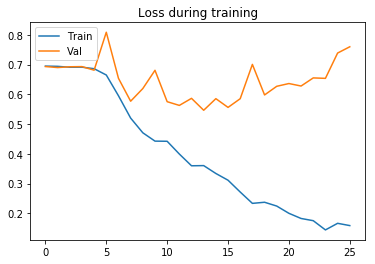

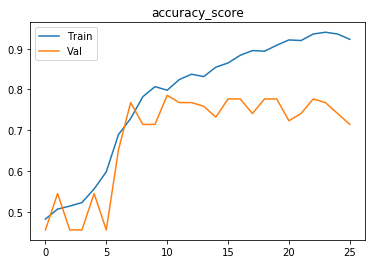

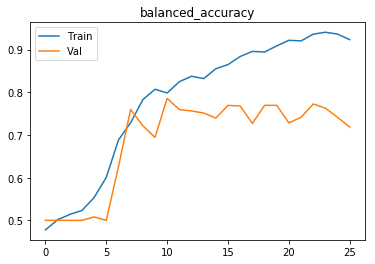

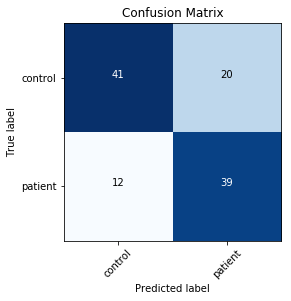

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    50] loss: 0.69325
Time elapsed: 0h:0m:8s
train accuracy_score: 50.22 %
train balanced_accuracy: 50.61 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694615
[1,    50] loss: 0.69182
Time elapsed: 0h:0m:19s
train accuracy_score: 50.36 %
train balanced_accuracy: 49.45 %
val accuracy_score: 61.61 %
val balanced_accuracy: 62.66 %
Val loss: 0.691957
[2,    50] loss: 0.69248
Time elapsed: 0h:0m:30s
train accuracy_score: 51.38 %
train balanced_accuracy: 51.81 %
val accuracy_score: 55.36 %
val balanced_accuracy: 50.98 %
Val loss: 0.690166
[3,    50] loss: 0.69075
Time elapsed: 0h:0m:40s
train accuracy_score: 53.12 %
train balanced_accuracy: 53.18 %
val accuracy_score: 66.96 %
val balanced_accuracy: 65.65 %
Val loss: 0.689550
[4,    50] loss: 0.68844
Time elapsed: 0h:0m:51s
train accuracy_score: 55.15 %
train balanced_accuracy: 54.

val accuracy_score: 78.57 %
val balanced_accuracy: 77.60 %
Val loss: 0.489624
[43,    50] loss: 0.29493
Time elapsed: 0h:7m:52s
train accuracy_score: 88.39 %
train balanced_accuracy: 88.40 %
val accuracy_score: 78.57 %
val balanced_accuracy: 78.24 %
Val loss: 0.464373
[44,    50] loss: 0.26818
Time elapsed: 0h:8m:3s
train accuracy_score: 88.97 %
train balanced_accuracy: 88.98 %
val accuracy_score: 80.36 %
val balanced_accuracy: 80.20 %
Val loss: 0.481993
[45,    50] loss: 0.26167
Time elapsed: 0h:8m:13s
train accuracy_score: 87.37 %
train balanced_accuracy: 87.42 %
val accuracy_score: 78.57 %
val balanced_accuracy: 78.56 %
Val loss: 0.507836
Early stopping in epoch 46
Total time elapsed: 0h:8m:15s
Writing model to disk...
Best result during training: 0.81. Saving model..
Finished inner fold.


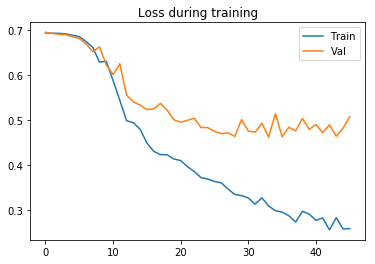

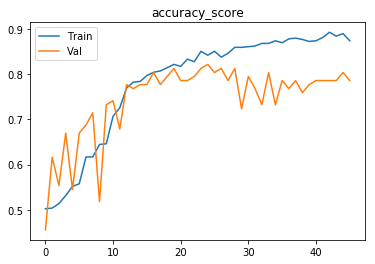

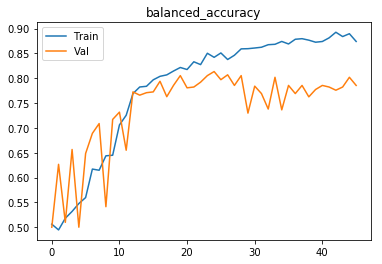

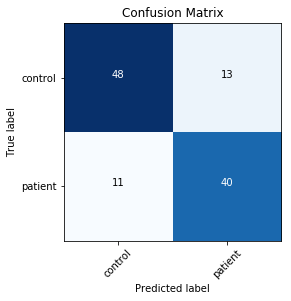

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    50] loss: 0.69763
[0,   100] loss: 0.69144
[0,   150] loss: 0.69848
Time elapsed: 0h:0m:18s
train accuracy_score: 51.96 %
train balanced_accuracy: 51.87 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.701901
[1,    50] loss: 0.69745
[1,   100] loss: 0.69276
[1,   150] loss: 0.69239
Time elapsed: 0h:0m:40s
train accuracy_score: 49.78 %
train balanced_accuracy: 49.54 %
val accuracy_score: 53.57 %
val balanced_accuracy: 49.18 %
Val loss: 0.688626
[2,    50] loss: 0.68778
[2,   100] loss: 0.68859
[2,   150] loss: 0.68310
Time elapsed: 0h:1m:1s
train accuracy_score: 55.30 %
train balanced_accuracy: 55.44 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.843979
[3,    50] loss: 0.65216
[3,   100] loss: 0.61859
[3,   150] loss: 0.54349
Time elapsed: 0h:1m:23s
train accuracy_score: 70.83 %
train balanced_acc

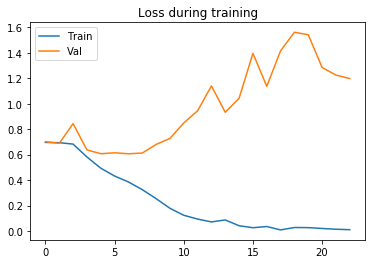

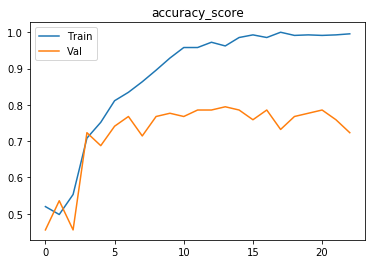

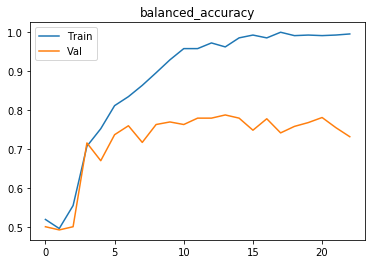

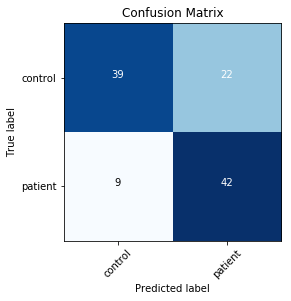

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    50] loss: 0.69447
[0,   100] loss: 0.69311
Time elapsed: 0h:0m:16s
train accuracy_score: 51.52 %
train balanced_accuracy: 51.43 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.689323
[1,    50] loss: 0.68990
[1,   100] loss: 0.69183
Time elapsed: 0h:0m:35s
train accuracy_score: 52.54 %
train balanced_accuracy: 52.54 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694265
[2,    50] loss: 0.69198
[2,   100] loss: 0.68561
Time elapsed: 0h:0m:54s
train accuracy_score: 53.70 %
train balanced_accuracy: 53.74 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.716660
[3,    50] loss: 0.69284
[3,   100] loss: 0.68881
Time elapsed: 0h:1m:13s
train accuracy_score: 53.85 %
train balanced_accuracy: 53.90 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.702909
[4,    

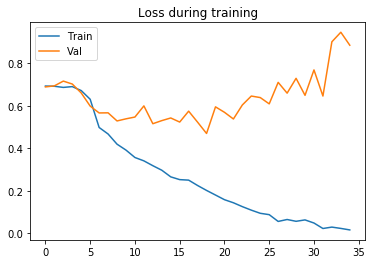

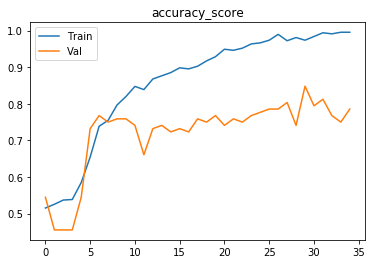

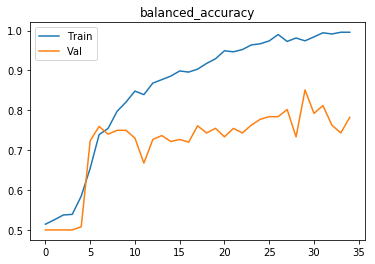

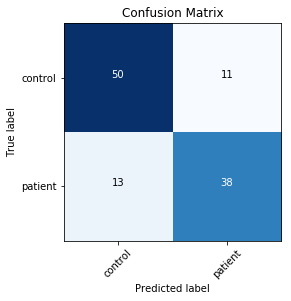

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    50] loss: 0.69151
[0,   100] loss: 0.69624
Time elapsed: 0h:0m:11s
train accuracy_score: 51.81 %
train balanced_accuracy: 51.21 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.690795
[1,    50] loss: 0.69447
[1,   100] loss: 0.69417
Time elapsed: 0h:0m:24s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.73 %
val accuracy_score: 68.75 %
val balanced_accuracy: 67.78 %
Val loss: 0.692307
[2,    50] loss: 0.69255
[2,   100] loss: 0.68987
Time elapsed: 0h:0m:38s
train accuracy_score: 53.41 %
train balanced_accuracy: 53.57 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695496
[3,    50] loss: 0.69163
[3,   100] loss: 0.68842
Time elapsed: 0h:0m:51s
train accuracy_score: 52.83 %
train balanced_accuracy: 52.58 %
val accuracy_score: 54.46 %
val balanced_accuracy: 56.75 %
Val loss: 0.689373
[4,   

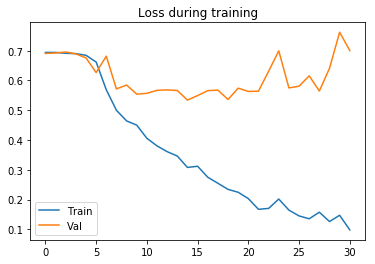

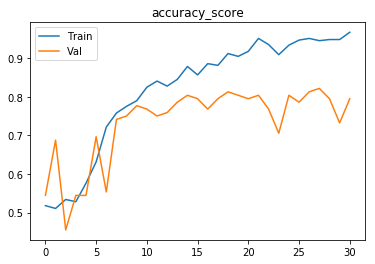

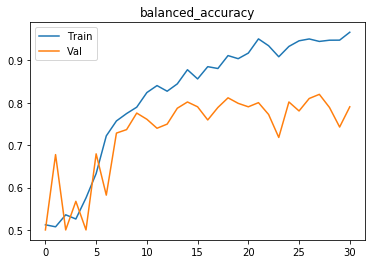

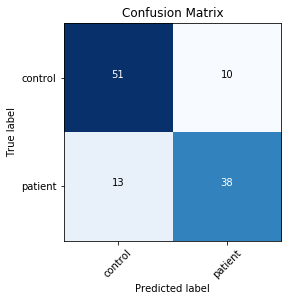

Finished outer fold.
{'final_acc': 0.7855994856959176, 'best_acc': 0.8135647701703632, 'final_iter': 46, 'best_iter': 25, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 1}
################################
################################
All accuracies: [0.7779732582688248, 0.7945109078114005, 0.7952146375791695, 0.818789584799437, 0.7568613652357494, 0.8772727272727272, 0.8045454545454545, 0.7306818181818182, 0.805681818181818, 0.7977272727272727, 0.7950592885375494, 0.8310276679841897, 0.7440711462450592, 0.8403162055335969, 0.6881422924901185, 0.7578947368421052, 0.8307017543859649, 0.7723684210526316, 0.8188596491228072, 0.8364035087719298, 0.8258678611422172, 0.841545352743561, 0.767077267637178, 0.767077267637178, 0.8240014930944383, 0.8079777365491652, 0.8939393939393939, 0.8155534941249227, 0.7968460111317255, 0.8787878787878788, 0.8117063492063492, 0.7706349206349206, 0.8309523809523809, 0.7583333333333333, 0.7626984126984127

In [17]:
fold_metric, models = run(net=None, data=None,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [18]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [19]:
training_res = [{'final_acc': 0.818789584799437, 'best_acc': 0.8918015482054891, 'final_iter': 32, 'best_iter': 22, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 3}, {'final_acc': 0.8772727272727272, 'best_acc': 0.9193181818181817, 'final_iter': 38, 'best_iter': 22, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 0}, {'final_acc': 0.8310276679841897, 'best_acc': 0.8984189723320157, 'final_iter': 65, 'best_iter': 59, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1}, {'final_acc': 0.8307017543859649, 'best_acc': 0.8307017543859649, 'final_iter': 41, 'best_iter': 41, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}, {'final_acc': 0.8258678611422172, 'best_acc': 0.8434117207913402, 'final_iter': 34, 'best_iter': 32, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}, {'final_acc': 0.8939393939393939, 'best_acc': 0.8939393939393939, 'final_iter': 38, 'best_iter': 38, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}, {'final_acc': 0.8309523809523809, 'best_acc': 0.848015873015873, 'final_iter': 24, 'best_iter': 19, 'params': {'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.8163919413919415, 'best_acc': 0.8685897435897436, 'final_iter': 23, 'best_iter': 17, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}, {'final_acc': 0.8743589743589744, 'best_acc': 0.891025641025641, 'final_iter': 56, 'best_iter': 39, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1}, {'final_acc': 0.7855994856959176, 'best_acc': 0.8135647701703632, 'final_iter': 46, 'best_iter': 25, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 1}]

In [20]:
print(len(training_res))
res_df = pd.DataFrame(training_res)

10


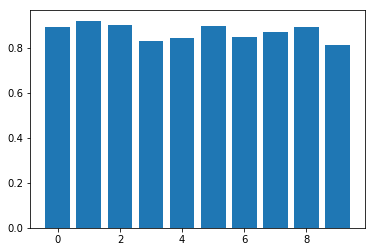

0.8698787599274006
0.8384901771923143


In [21]:
plt.bar(np.arange(len(res_df["best_acc"])), res_df["best_acc"])
plt.show()
print(np.mean(res_df["best_acc"]))
print(np.mean(res_df["final_acc"]))

In [22]:
print(np.mean(res_df["final_iter"]))

39.7


In [23]:
print(res_df["final_iter"])

0    32
1    38
2    65
3    41
4    34
5    38
6    24
7    23
8    56
9    46
Name: final_iter, dtype: int64


In [24]:
from collections import OrderedDict

In [25]:
metrics = []
random_states = np.arange(20, 30) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
    
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    test_h5 = h5py.File(train_data_path.replace("train", "holdout") + str(r) + ".h5", 'r')

    X_test, y_test = np.array(test_h5['X']), np.array(test_h5['y'])

    # dataset overview
    print("# of patients {}, # of healthy controls {}".format(np.sum(y_test), len(y_test)-np.sum(y_test)))

    print(len(y_test))

    if zero_one_normalize:
        intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
        adni_data_test= ADNIDataset(X_test, y_test, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    else:
        adni_data_test = ADNIDataset(X_test, y_test, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

    test_h5.close()
    
    test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False)
    
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Outer fold 0
# of patients 65, # of healthy controls 98
163
Bal. accuracy 71.617 %
ROC AUC Score 83.124 %
Sensitivity 73.846 %
Specificity 69.388 %
Outer fold 1
# of patients 77, # of healthy controls 99
176
Bal. accuracy 81.818 %
ROC AUC Score 89.899 %
Sensitivity 81.818 %
Specificity 81.818 %
Outer fold 2
# of patients 78, # of healthy controls 100
178
Bal. accuracy 86.513 %
ROC AUC Score 94.013 %
Sensitivity 91.026 %
Specificity 82.000 %
Outer fold 3
# of patients 70, # of healthy controls 93
163
Bal. accuracy 81.052 %
ROC AUC Score 86.882 %
Sensitivity 72.857 %
Specificity 89.247 %
Outer fold 4
# of patients 73, # of healthy controls 96
169
Bal. accuracy 67.908 %
ROC AUC Score 78.410 %
Sensitivity 71.233 %
Specificity 64.583 %
Outer fold 5
# of patients 73, # of healthy controls 97
170
Bal. accuracy 86.796 %
ROC AUC Score 91.809 %
Sensitivity 84.932 %
Specificity 88.660 %
Outer fold 6
# of patients 68, # of healthy controls 90
158
Bal. accuracy 73.219 %
ROC AUC Score 77.843 %
Sensi